In [1]:
import sys
sys.path.insert(0, '/data/schoiaj/repos/nli_explain')
import json

import pandas as pd

from explainers.archipelago.viz.text import viz_text
from utils.data_utils import get_clean_token_list
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.read_csv('../data/e-SNLI/esnli_test_processed_1k.csv')

In [110]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
def analyze_explanation(df, explanation, idx, topk=1, texts=None, gold_label=None, no_main=True):
    
    
    if texts is None:
        texts = df.iloc[idx][['Sentence1', 'Sentence2']].tolist()
    cleaned_premise = [w.lower() for w in get_clean_token_list(texts[0])]
    cleaned_hypothesis = [w.lower() for w in get_clean_token_list(texts[1])]

    tokens = cleaned_premise + ['->'] + cleaned_hypothesis
    
    exp = [eval(k) for k,v in sorted(explanation[idx]['pred_rationales'].items(), key=lambda x: x[1], reverse=True)]
    
    if gold_label is None:
        gold_label = df.iloc[idx]['gold_label']
    print("texts:", texts)
    print("gold label:", gold_label)
    print("pred label:", explanation[idx]['pred_label'])
    print("explanations:", exp)
    print("interactions_vote:", df.iloc[idx]['interactions_vote'])
    print("interactions_union:", df.iloc[idx]['interactions_union'])
    
    explanation_idx = {}

    for i, interaction in enumerate(exp):
        if len(interaction[0]) + len(interaction[1]) == 4:
            if not (len(interaction[0]) == 2 and len(interaction[1]) == 2):
                continue
        indices = []
        tok_idx = -1
        for pre_token in interaction[0]:
            if pre_token not in cleaned_premise[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_premise[tok_idx + 1:].index(pre_token)
            indices.append(tok_idx)
        tok_idx = -1
        for hyp_token in interaction[1]:
            if hyp_token not in cleaned_hypothesis[tok_idx + 1:]:
                continue
            tok_idx = tok_idx + 1 + cleaned_hypothesis[tok_idx + 1:].index(hyp_token)
            indices.append(tok_idx + len(cleaned_premise) + 1)
        if indices:
            explanation_idx[tuple(indices)] = len(explanation[idx]['pred_rationales']) - i
        if topk is not None and i + 1 >= topk:
            break
    
    for i in range(len(tokens)):
        if no_main or (i,) not in explanation_idx:
            explanation_idx[(i,)] = 0
        
    fig = viz_text(explanation_idx, tokens)
    display(fig)
    plt.close()

In [79]:
from explainers.archipelago.get_explainer import ArchExplainerInterface
# from explainers.integrated_hessians.IH_explainer import IHBertExplainer
# from explainers.naive_explain.naive_explainer import NaiveExplainer
from explainers.mask_explain.mask_explainer import MaskExplainer
from explainers.lime_baseline import LimeExplainer

arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='arch')
cross_arch = ArchExplainerInterface('bert-base',
                        device='cuda',
                        explainer_class='cross_arch')
# naive = NaiveExplainer('bert-base',
#                     device='cuda')
# IH = IHBertExplainer('bert-base',
#                     device='cuda')
# explain_kwargs = dict(batch_size=16,
#                       num_samples=128,
#                       use_expectation=False,
#                       do_cross_merge=False,
#                       get_cross_effects=True)
mask_explain = MaskExplainer('bert-base',
                        device='cuda',
                        baseline_token='attention+[MASK]')


lime = LimeExplainer('bert-base',
                        device='cuda')
explain_kwargs = dict(batch_size=32, mask_n=5000)

contradiction


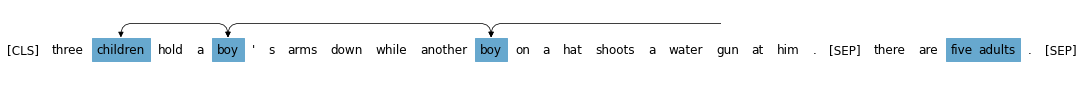

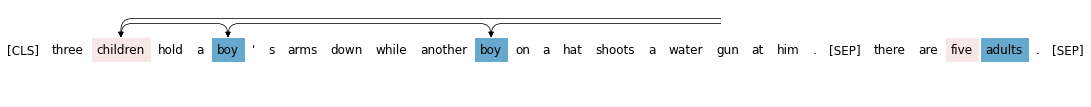

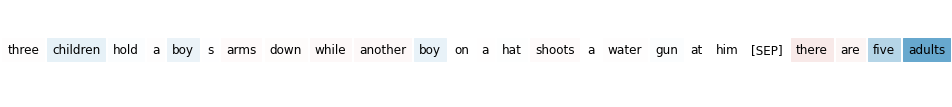

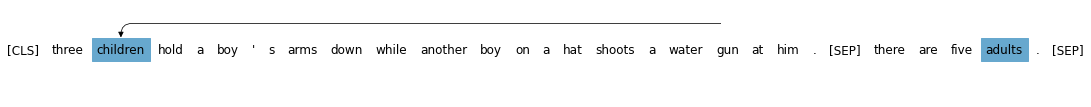

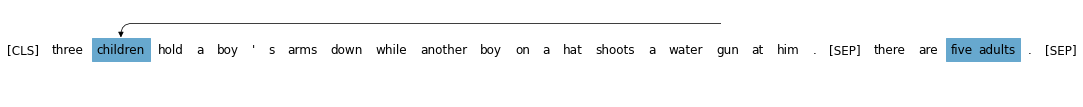

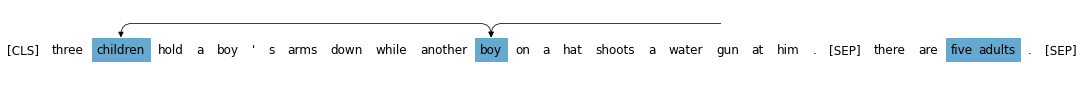

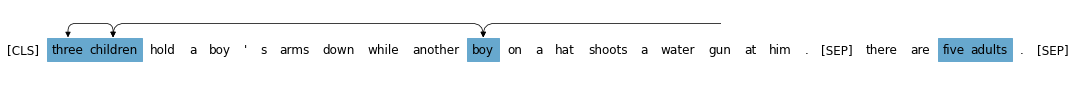

In [116]:
# sents = df.iloc[761][['Sentence1', 'Sentence2']].tolist()
# sents = df.iloc[631][['Sentence1', 'Sentence2']].tolist()
sents = ['three children hold a boy\'s arms down while another boy on a hat shoots a water gun at him.', 'there are five adults.']
# sents = ['that was an exceptionally funny movie.', "the movie was great."]
target = None
# target = arch.get_label_map()["contradiction"]
explanation, tokens, pred = arch.explain(*sents, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:2]}
print(arch.get_label_map(inv=True)[pred])
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = cross_arch.explain(*sents, do_cross_merge=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:2]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = lime.explain(*sents, mask_n=5000, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:None]}
for i in range(len(tokens)):
    if (i,) not in explanation:
        explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(2,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(3,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(4,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)

explanation, tokens, pred = mask_explain.explain(*sents, interaction_order=(5,), 
                                                 mask_p=0.5, mask_n=5000, top_p=0.3, 
                                                 do_buildup=True, output_indices=target)
explanation = {k: v for k, v in sorted(explanation.items(), key=lambda x: x[1], reverse=True)[:1]}
for i in range(len(tokens)):
    explanation[(i,)] = 0
fig = viz_text(explanation, tokens)


bert-base_arch-5_test_BT=[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men', 'outdoor'), ('women', 'gym'))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


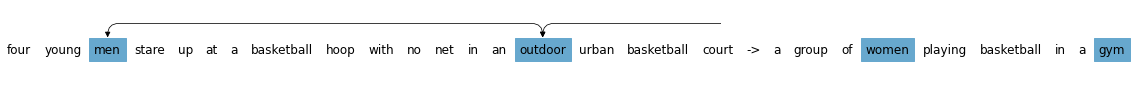


bert-base_cross_arch-5_test_BT=[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',)), ((), ('group', 'of', 'basketball', 'a')), (('basketball', 'basketball'), ())]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


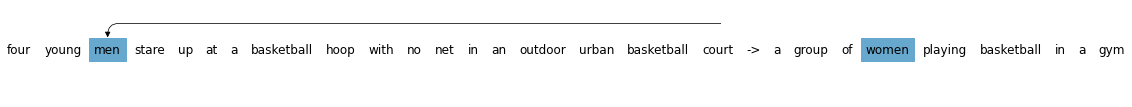


bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women', 'gym'))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


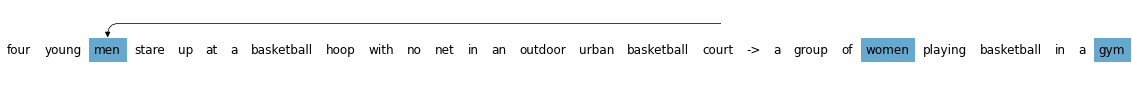


bert-base_lime-5000_test_BT=[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('gym',)), ((), ('women',)), (('men',), ()), (('outdoor',), ()), (('urban',), ()), ((), ('in',)), (('stare',), ()), (('Four',), ()), (('at',), ()), (('net',), ())]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


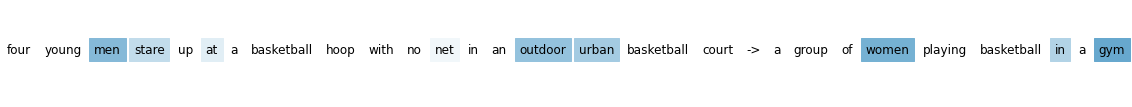


bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',)), (('outdoor',), ('gym',)), (('urban',), ('gym',)), (('men',), ('gym',)), (('outdoor',), ('women',)), (('stare',), ('gym',)), (('young',), ('women',)), (('urban',), ('women',)), (('stare',), ('women',)), (('four',), ('women',)), (('four',), ('gym',)), (('net',), ('gym',)), (('in',), ('women',)), (('an',), ('women',)), (('in',), ('gym',)), (('an',), ('gym',)), (('a',), ('women',)), (('young',), ('gym',)), (('up',), ('women',)), (('at',), ('women',))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


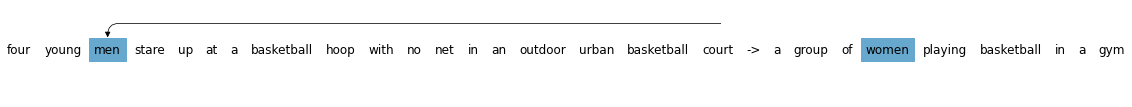


bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('group', 'women')), (('men',), ('women', 'gym')), (('men',), ('women', 'a')), (('four', 'men'), ('women',)), (('men',), ('a', 'women')), (('men', 'outdoor'), ('women',)), (('men',), ('women', 'in')), (('young', 'men'), ('women',)), (('men', 'at'), ('women',)), (('men', 'in'), ('women',))]
interactions_vote: [(['young', 'men'], ['women'])]
interactions_union: [(['young', 'men'], ['women']), (['young', 'men'], ['gym']), (['outdoor'], ['women']), (['outdoor'], ['gym'])]


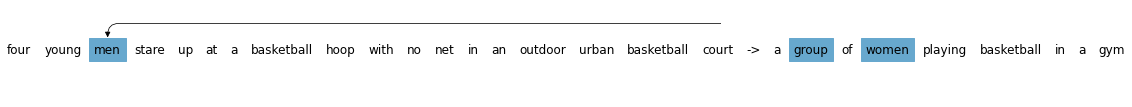


bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Four young men stare up at a basketball hoop with no net, in an outdoor, urban basketball court.', 'A group of women playing basketball in a gym.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('group', 'women', 'gym')), (('men',), ('group', 'women', 'a')), (('men',), ('women', 'in', 'gym')), (('men', 'outdoor'), ('women', 'gym')), (('four', 'men'), ('women', 'gym')), (('men',), ('women', 'a', 'gym')), (('four', 'men'), ('group', 'women')), (('men',), ('a', 'women', 'gym')), (('men',), ('group', 'of', 'women')), (('men',), ('women', 'in', 'a')), (('men',), ('a', 'women', 'a')), (('men', 'outdoor'), ('women', 'a')), (('men', 'outdoor'), ('group', 'women')), (('men', 'urban'), ('women', 'gym')), (('four', 'men'), ('women', 'a')), (('men', 'court'), ('women', 'gym')), (('men', 'up'), ('women', 'gym')), (('men',), ('a', 'group', 'women')), (('young', 'men'), ('group'

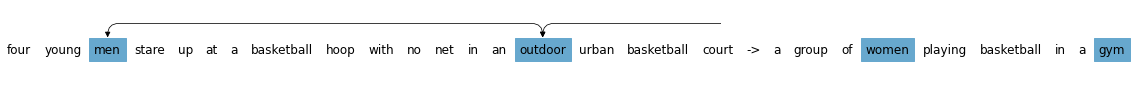

In [111]:
# failure
# idx = 929  # entail
# idx = 305  # contradict
# idx = 274  # contra
# idx = 267  # entail
# idx = 194  # contra  model is wrong, and the explanations are weird
# idx = 909  # contra  (counting)
# idx = 77  # voice (passive active)

# all success
# idx = 270  # contradict
# idx = 84  # entail
# idx = 532  # entail, copy paste
# idx = 640  # neutral, more or less copy paste

# my success
# idx = 283  # entail  (good example)
# idx = 137  # contra  (not rlly success, just difference)
# idx = 109  # contra  (kinda?)
# idx = 179  # entail  (kinda?)  (but the model was wrong)
# idx = 757  # contra  (the model was wrong, but the rationale make the most sense)
# idx = 768  # neutral (less noisy)
# my fail
# idx = 134 # entail
# idx = 45  # entail

# lime vs mask
idx = 894
idx = 779
idx = 986
# try later: with different label
# idx = 129  # pred:neutral gold:entail

# pairwise
# print('pairwise')
# exp_files = ['bert-base_arch_pair-5_10_test_BT=[MASK]_interaction.json',
#              'bert-base_cross_arch_pair-5_10_test_BT=[MASK]_interaction.json',
#              'bert-base_naive_occlusion_10_test_BT=[MASK]_interaction.json',
#              'bert-base_IH_10_test_BT=[MASK]_interaction.json',
#              'bert-base_mask_explain-2-p0.5-n10000-inv0_10_test_BT=attention+[MASK]_interaction.json',
#              ]


exp_files = ['bert-base_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
             'bert-base_lime-5000_test_BT=[MASK].json',
             'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
             ]
for exp_file in exp_files:
    print()
    print(exp_file)
    with open(f'../explanations/{exp_file}', 'r') as f:
        explanations = json.load(f)

    analyze_explanation(df, explanations, idx, topk=None if 'lime' in exp_file else 1, no_main='lime' not in exp_file)

In [59]:
pd.set_option('display.max_colwidth', None)
df[df['gold_label'] == 'contradiction'][['Sentence1', 'Sentence2', 'gold_label']].sample(50)

,Sentence1,Sentence2,gold_label
508,Soldiers are holding guns and peeking around a building.,Soldiers are holding guns in a large featureless desert.,contradiction
705,A man cooking with fire in like 5 pots at the same time!,A man is cooking with a bunch of ovens.,contradiction
900,kids are looking at something on a table.,Some kids are burning the table down.,contradiction
235,A group of women observing an event while one in military attire takes a photograph,A group of people got ran over by a bus.,contradiction
779,A man wearing a hat and carrying a bag,A man is walking empty handed.,contradiction
299,Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.,Nobody is drying clothes.,contradiction
743,A cyclist in a red and white uniform is biking across a garage full of people.,The man is wearing a pijama.,contradiction
175,Workers standing on a lift.,Workers walk home from work,contradiction
995,A man in a green shirt hovers above the ground in the laundry room.,The man is wearing a red shirt.,contradiction
346,A boy rollerskating in the street.,A boy is sleeping,contradiction


190 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('adjusting', 'bracelet'), ('two', 'women', 'making', 'pancakes'))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


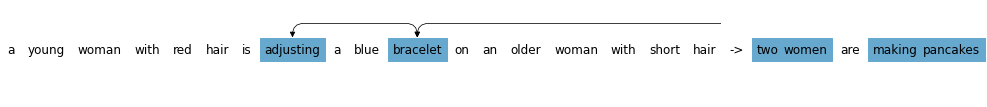





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('pancakes',)), (('adjusting',), ('pancakes',)), (('woman',), ('pancakes',)), (('hair',), ('pancakes',)), ((), ('pancakes',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


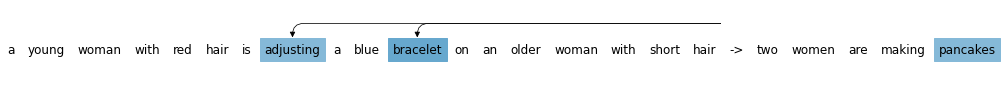





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('pancakes',)), ((), ('women',)), (('bracelet',), ()), (('young',), ()), (('a',), ()), (('on',), ()), ((), ('are',)), (('is',), ()), (('A',), ())]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


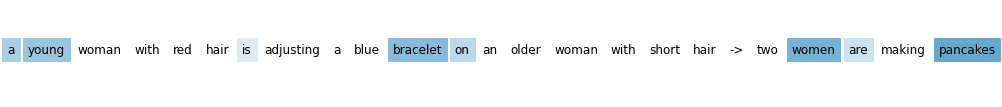





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('pancakes',)), (('adjusting',), ('pancakes',)), (('short',), ('pancakes',)), (('young',), ('pancakes',)), (('an',), ('pancakes',)), (('hair',), ('pancakes',)), (('on',), ('pancakes',)), (('woman',), ('pancakes',)), (('a',), ('pancakes',)), (('with',), ('pancakes',)), (('red',), ('pancakes',)), (('older',), ('pancakes',)), (('is',), ('pancakes',)), (('blue',), ('pancakes',)), (('bracelet',), ('are',)), (('short',), ('are',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


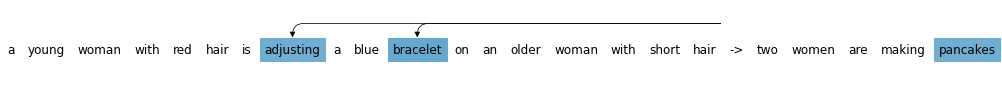





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('bracelet',), ('making', 'pancakes')), (('adjusting',), ('making', 'pancakes')), (('hair',), ('making', 'pancakes')), (('bracelet',), ('women', 'pancakes')), (('adjusting', 'bracelet'), ('pancakes',)), (('bracelet', 'on'), ('pancakes',)), (('bracelet',), ('two', 'pancakes')), (('bracelet', 'short'), ('pancakes',)), (('a', 'bracelet'), ('pancakes',))]
interactions_vote: [(['adjusting'], ['making', 'pancakes']), (['bracelet'], ['making', 'pancakes'])]
interactions_union: [(['adjusting', 'a', 'blue', 'bracelet'], ['making', 'pancakes'])]


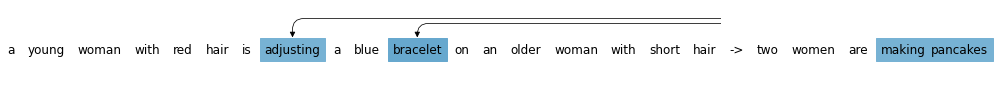





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young woman with red-hair is adjusting a blue bracelet on an older woman with short hair.', 'Two women are making pancakes.']
gold label: contradiction
pred label: contradiction
explanations: [(('adjusting', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'short'), ('making', 'pancakes')), (('bracelet', 'an'), ('making', 'pancakes')), (('bracelet',), ('two', 'making', 'pancakes')), (('a', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'hair'), ('making', 'pancakes')), (('bracelet', 'on'), ('making', 'pancakes')), (('adjusting', 'hair'), ('making', 'pancakes')), (('woman', 'bracelet'), ('making', 'pancakes')), (('red', 'bracelet'), ('making', 'pancakes')), (('bracelet', 'woman'), ('making', 'pancakes')), (('bracelet', 'with'), ('making', 'pancakes')), (('hair', 'bracelet'), ('making', 'pancakes')), (('bracelet',), ('women', 'making', 'pancakes')), (('with', 'bracelet'), ('making', '

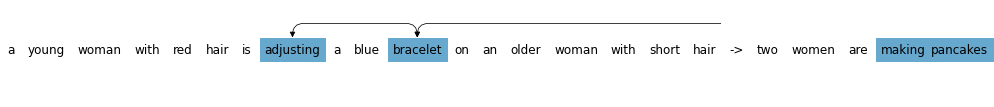





462 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow', 'snowballs'), ('are', 'somewhere', 'cold'))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


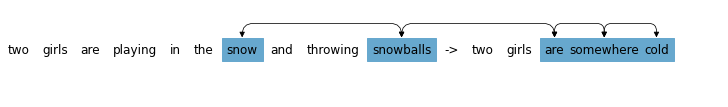





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow', 'snowballs'), ('cold',)), (('girls',), ('girls',)), (('in', 'snow'), ('somewhere',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


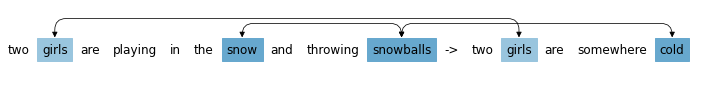





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [((), ('somewhere',)), (('snow',), ()), (('girls',), ()), ((), ('Two',)), (('snowballs',), ()), ((), ('are',)), ((), ()), (('the',), ()), (('in',), ()), (('and',), ())]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), (['playing', 'in', 'the', 'snow'], ['somewhere', 'cold']), (['throwing', 'snowballs'], ['Two', 'girls']), (['throwing', 'snowballs'], ['somewhere', 'cold'])]


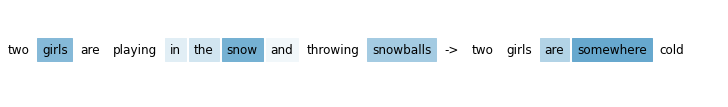





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow',), ('somewhere',)), (('snowballs',), ('somewhere',)), (('girls',), ('somewhere',)), (('the',), ('somewhere',)), (('in',), ('somewhere',)), (('are',), ('somewhere',)), (('throwing',), ('somewhere',)), (('and',), ('somewhere',)), (('two',), ('somewhere',)), (('playing',), ('somewhere',)), (('snowballs',), ('cold',)), (('girls',), ('girls',)), (('snow',), ('cold',)), (('girls',), ('two',)), (('snowballs',), ('are',)), (('snowballs',), ('two',)), (('snow',), ('two',)), (('snow',), ('are',)), (('two',), ('two',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interac

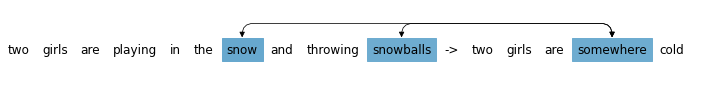





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('snow',), ('somewhere', 'cold')), (('snowballs',), ('somewhere', 'cold')), (('girls', 'snow'), ('somewhere',)), (('girls', 'snowballs'), ('somewhere',)), (('snowballs',), ('are', 'somewhere')), (('snow',), ('are', 'somewhere')), (('girls',), ('somewhere', 'cold')), (('girls',), ('are', 'somewhere')), (('girls',), ('two', 'somewhere')), (('the', 'snow'), ('somewhere',))]
interactions_vote: [(['playing'], ['Two', 'girls']), (['playing'], ['somewhere', 'cold']), (['snow'], ['Two', 'girls']), (['snow'], ['somewhere', 'cold']), (['snowballs'], ['Two', 'girls']), (['snowballs'], ['somewhere', 'cold'])]
interactions_union: [(['Two', 'girls'], ['Two', 'girls']), (['Two', 'girls'], ['somewhere', 'cold']), (['playing', 'in', 'the', 'snow'], ['Two', 'girls']), 

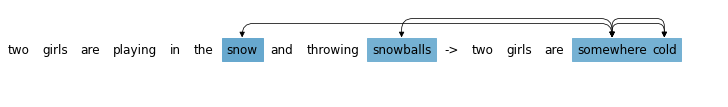





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two girls are playing in the snow and throwing snowballs.', 'Two girls are somewhere cold.']
gold label: entailment
pred label: entailment
explanations: [(('girls', 'snow'), ('somewhere', 'cold')), (('snowballs',), ('are', 'somewhere', 'cold')), (('snow',), ('are', 'somewhere', 'cold')), (('girls', 'snowballs'), ('somewhere', 'cold')), (('girls', 'snow'), ('are', 'somewhere')), (('girls', 'snowballs'), ('are', 'somewhere')), (('snow', 'snowballs'), ('somewhere', 'cold')), (('in', 'snow'), ('somewhere', 'cold')), (('the', 'snow'), ('somewhere', 'cold')), (('snow',), ('two', 'somewhere', 'cold')), (('are', 'snow'), ('somewhere', 'cold')), (('the', 'snowballs'), ('somewhere', 'cold')), (('in', 'snowballs'), ('somewhere', 'cold')), (('are', 'snowballs'), ('somewhere', 'cold')), (('snowballs',), ('two', 'somewhere', 'cold')), (('and', 'snowballs'), ('somewhere', 'cold')), (('girls', 'are', 'snow')

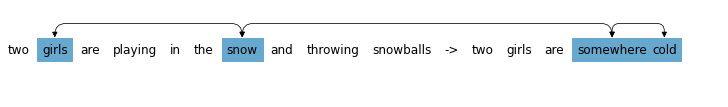





523 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('people', 'shopping', 'market'), ('watching', 'television'))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


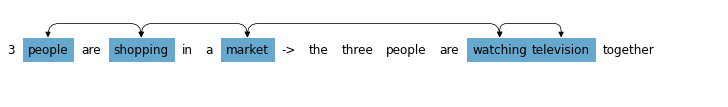





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('3', 'market'), ('three', 'television')), (('shopping',), ('television',))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


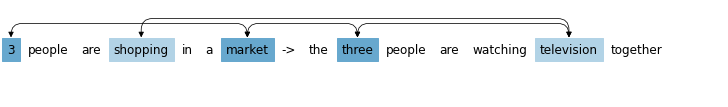





bert-base_lime-5000_test_BT=[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('television',)), ((), ('three',)), (('shopping',), ()), (('market',), ()), ((), ('watching',)), ((), ('The',)), ((), ()), (('people',), ()), (('in',), ()), ((), ('people',)), (('are',), ()), ((), ('are',)), (('a',), ())]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching', 'television', 'together'])]


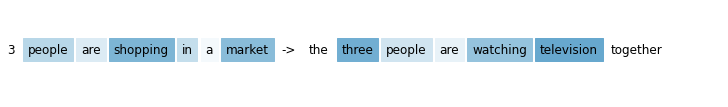





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('market',), ('television',)), (('shopping',), ('television',)), (('are',), ('television',)), (('in',), ('television',)), (('a',), ('television',)), (('people',), ('television',)), (('3',), ('television',)), (('shopping',), ('watching',)), (('shopping',), ('three',)), (('market',), ('watching',)), (('shopping',), ('are',)), (('market',), ('three',)), (('shopping',), ('together',)), (('shopping',), ('the',)), (('shopping',), ('people',)), (('are',), ('watching',)), (('market',), ('together',)), (('in',), ('three',)), (('a',), ('three',)), (('market',), ('are',))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'televisi

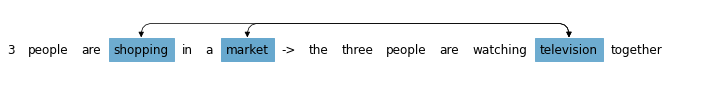





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('market',), ('watching', 'television')), (('shopping',), ('watching', 'television')), (('market',), ('television', 'together')), (('shopping',), ('television', 'together')), (('shopping', 'market'), ('television',)), (('market',), ('people', 'television')), (('market',), ('the', 'television')), (('market',), ('three', 'television')), (('a', 'market'), ('television',)), (('shopping',), ('three', 'television'))]
interactions_vote: [(['shopping'], ['watching', 'television']), (['market'], ['watching', 'television'])]
interactions_union: [(['people'], ['people']), (['people'], ['watching', 'television', 'together']), (['shopping'], ['people']), (['shopping'], ['watching', 'television', 'together']), (['market'], ['people']), (['market'], ['watching',

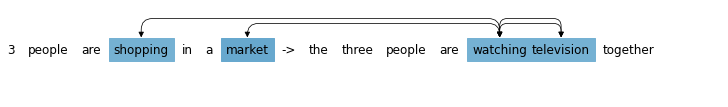





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['3 people are shopping in a market.', 'The three people are watching television together.']
gold label: contradiction
pred label: contradiction
explanations: [(('shopping', 'market'), ('watching', 'television')), (('market',), ('watching', 'television', 'together')), (('a', 'market'), ('watching', 'television')), (('people', 'market'), ('watching', 'television')), (('market',), ('three', 'watching', 'television')), (('market',), ('people', 'watching', 'television')), (('are', 'market'), ('watching', 'television')), (('market',), ('the', 'watching', 'television')), (('in', 'market'), ('watching', 'television')), (('shopping', 'market'), ('television', 'together')), (('shopping',), ('watching', 'television', 'together')), (('market',), ('are', 'watching', 'television')), (('3', 'market'), ('watching', 'television')), (('shopping',), ('three', 'watching', 'television')), (('people', 'shopping'), 

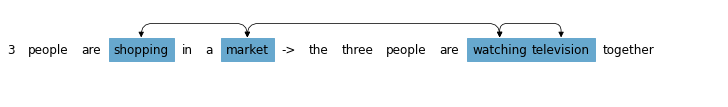





0 score 0.8333333333333333
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


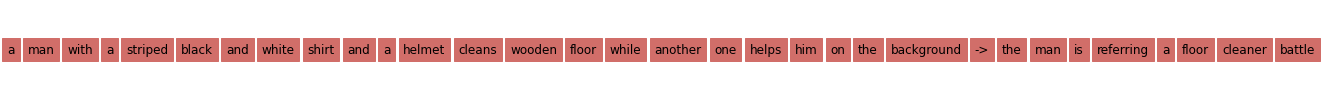





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans',), ('battle',)), (('floor',), ('referring',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


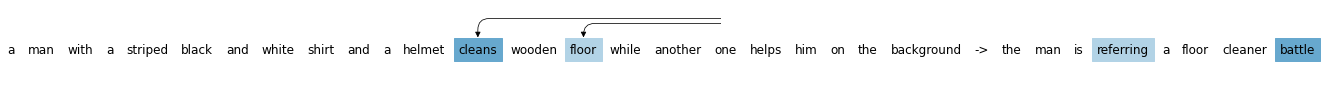





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('battle',)), (('cleans',), ()), (('helps',), ()), (('helmet',), ()), (('striped',), ()), (('and',), ()), (('with',), ()), (('the',), ()), (('background',), ())]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


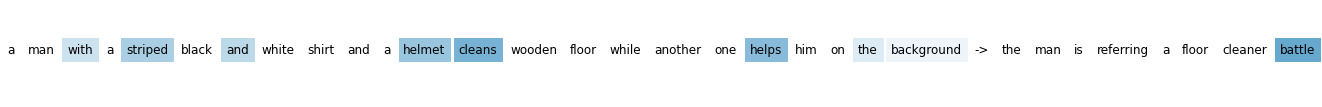





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans',), ('battle',)), (('helps',), ('battle',)), (('while',), ('battle',)), (('black',), ('battle',)), (('on',), ('battle',)), (('shirt',), ('battle',)), (('striped',), ('battle',)), (('white',), ('battle',)), (('man',), ('battle',)), (('and',), ('battle',)), (('the',), ('battle',)), (('one',), ('battle',)), (('background',), ('battle',)), (('a',), ('battle',)), (('him',), ('battle',)), (('with',), ('battle',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


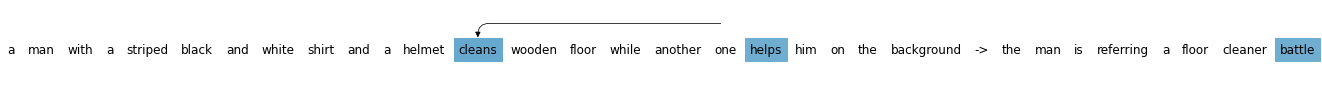





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans', 'helps'), ('battle',)), (('cleans',), ('battle',)), (('a', 'cleans'), ('battle',)), (('and', 'cleans'), ('battle',)), (('striped', 'cleans'), ('battle',)), (('cleans',), ('man', 'battle')), (('cleans', 'while'), ('battle',)), (('cleans',), ('floor', 'battle')), (('cleans', 'background'), ('battle',))]
interactions_vote: [(['cleans'], ['battle'])]
interactions_union: [(['cleans'], ['referring']), (['cleans'], ['floor', 'cleaner', 'battle']), (['helps'], ['referring']), (['helps'], ['floor', 'cleaner', 'battle'])]


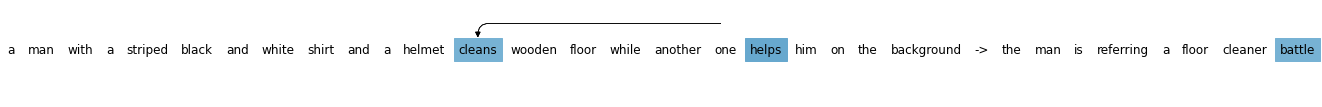





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man with a striped black and white shirt and a helmet cleans wooden floor while another one helps him on the background.', 'The man is referring a floor cleaner battle.']
gold label: contradiction
pred label: contradiction
explanations: [(('cleans', 'helps', 'the'), ('battle',)), (('cleans', 'helps'), ('floor', 'battle')), (('striped', 'cleans', 'helps'), ('battle',)), (('cleans', 'while', 'helps'), ('battle',)), (('cleans', 'helps'), ('man', 'battle')), (('cleans', 'helps'), ('battle',)), (('man', 'cleans', 'helps'), ('battle',)), (('black', 'cleans', 'helps'), ('battle',)), (('shirt', 'cleans', 'helps'), ('battle',)), (('white', 'cleans', 'helps'), ('battle',)), (('cleans', 'another', 'helps'), ('battle',)), (('and', 'cleans', 'helps'), ('battle',)), (('cleans', 'helps', 'on'), ('battle',)), (('with', 'cleans', 'helps'), ('battle',)), (('cleans', 'helps', 'background'), ('battle',)), (('c

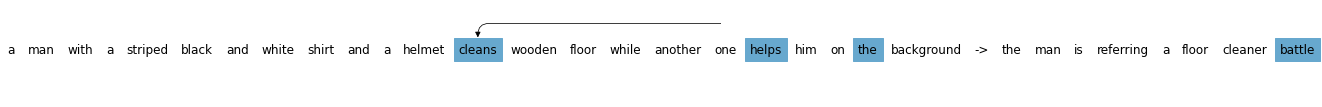





341 score 0.8333333333333333
bert-base_arch-5_test_BT=[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), ((), ('a', 'is', 'a')), (('guy', 'chick'), ('man',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


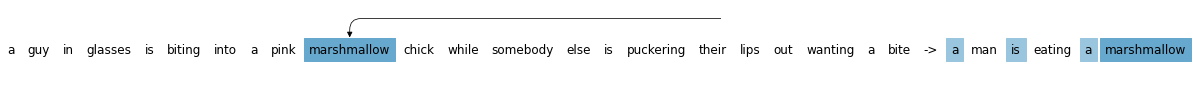





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), (('guy',), ('man',)), (('marshmallow',), ('eating',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


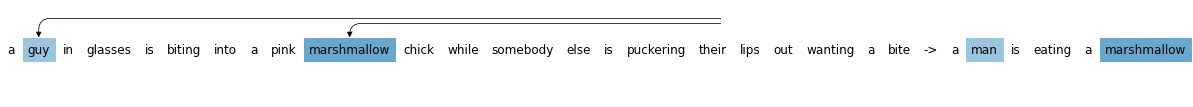





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ()), (('guy',), ()), ((), ('marshmallow',)), (('bite',), ()), ((), ('A',)), (('while',), ()), ((), ('a',)), (('biting',), ()), (('into',), ()), (('is',), ())]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]


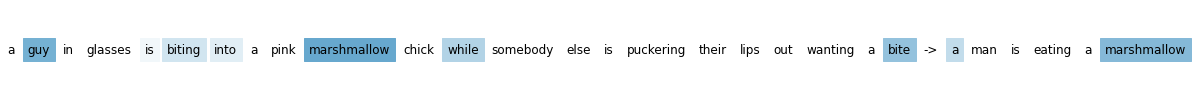





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('marshmallow',), ('marshmallow',)), (('marshmallow',), ('a',)), (('marshmallow',), ('is',)), (('guy',), ('marshmallow',)), (('guy',), ('man',)), (('guy',), ('a',)), (('guy',), ('is',)), (('bite',), ('marshmallow',)), (('biting',), ('marshmallow',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marsh

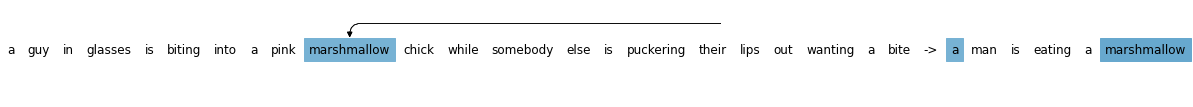





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('guy', 'marshmallow'), ('marshmallow',)), (('marshmallow',), ('marshmallow',)), (('guy', 'marshmallow'), ('man',)), (('marshmallow',), ('a',)), (('guy', 'marshmallow'), ('a',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['marshmallow'])]
interactions_union: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting'], ['man']), (['biting'], ['eating']), (['biting'], ['marshmallow']), (['marshmallow'], ['man']), (['marshmallow'], ['eating']), (['marshmallow'], ['m

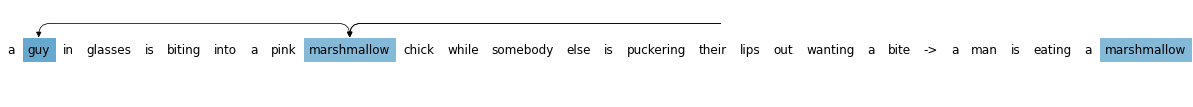





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A guy in glasses is biting into a pink marshmallow chick while somebody else is puckering their lips out wanting a bite.', 'A man is eating a marshmallow.']
gold label: entailment
pred label: entailment
explanations: [(('guy', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow'), ('a',)), (('guy', 'biting', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow', 'bite'), ('marshmallow',)), (('guy', 'marshmallow', 'bite'), ('a',)), (('marshmallow', 'bite'), ('marshmallow',)), (('marshmallow',), ('marshmallow',)), (('guy', 'marshmallow'), ('man',)), (('guy', 'biting', 'marshmallow'), ('man',)), (('guy', 'biting', 'marshmallow'), ('a',)), (('biting', 'marshmallow'), ('marshmallow',)), (('guy', 'pink', 'marshmallow'), ('marshmallow',)), (('guy', 'marshmallow', 'their'), ('marshmallow',))]
interactions_vote: [(['guy'], ['man']), (['guy'], ['eating']), (['guy'], ['marshmallow']), (['biting

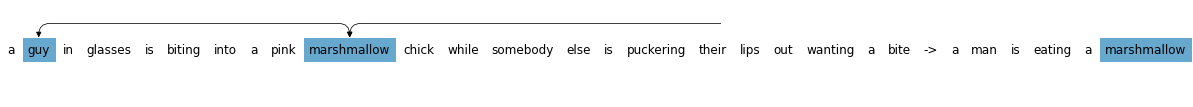





779 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'carrying'), ('empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


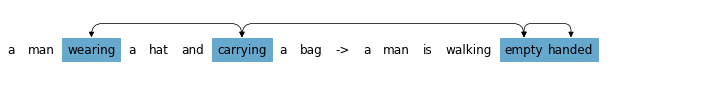





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('carrying', 'bag'), ('empty', 'handed')), (('wearing',), ('handed',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


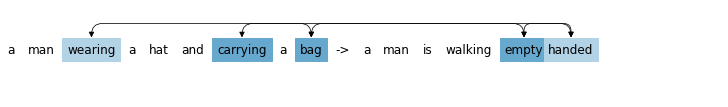





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('empty',)), ((), ('handed',)), ((), ('man',)), (('a',), ()), ((), ('walking',)), (('and',), ())]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


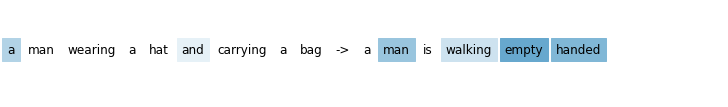





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('and',), ('empty',)), (('carrying',), ('empty',)), (('hat',), ('empty',)), (('wearing',), ('empty',)), (('a',), ('empty',)), (('man',), ('empty',)), (('bag',), ('empty',)), (('wearing',), ('man',)), (('hat',), ('is',)), (('and',), ('is',)), (('wearing',), ('handed',)), (('a',), ('man',)), (('wearing',), ('is',)), (('and',), ('man',)), (('a',), ('a',)), (('a',), ('is',)), (('hat',), ('a',))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


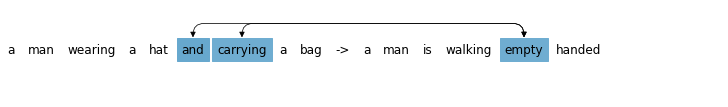





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('hat',), ('empty', 'handed')), (('wearing',), ('empty', 'handed')), (('and',), ('empty', 'handed')), (('carrying',), ('empty', 'handed')), (('bag',), ('empty', 'handed')), (('man',), ('empty', 'handed')), (('a',), ('empty', 'handed')), (('and',), ('walking', 'empty'))]
interactions_vote: [(['carrying', 'a', 'bag'], ['empty', 'handed'])]
interactions_union: [(['carrying', 'a', 'bag'], ['walking', 'empty', 'handed'])]


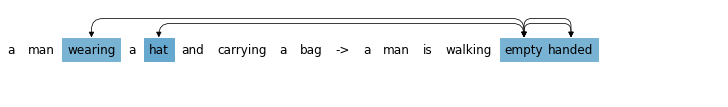





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man wearing a hat and carrying a bag', 'A man is walking empty handed.']
gold label: contradiction
pred label: contradiction
explanations: [(('wearing', 'hat'), ('empty', 'handed')), (('hat', 'and'), ('empty', 'handed')), (('and', 'a'), ('empty', 'handed')), (('wearing', 'a'), ('empty', 'handed')), (('wearing',), ('a', 'empty', 'handed')), (('a', 'and'), ('empty', 'handed')), (('and',), ('a', 'empty', 'handed')), (('hat',), ('is', 'empty', 'handed')), (('hat',), ('a', 'empty', 'handed')), (('wearing',), ('is', 'empty', 'handed')), (('wearing', 'and'), ('empty', 'handed')), (('hat', 'a'), ('empty', 'handed')), (('wearing', 'bag'), ('empty', 'handed')), (('man', 'hat'), ('empty', 'handed')), (('a', 'hat'), ('empty', 'handed')), (('hat', 'carrying'), ('empty', 'handed')), (('hat',), ('man', 'empty', 'handed')), (('wearing',), ('man', 'empty', 'handed'))]
interactions_vote: [(['carrying', 'a', 

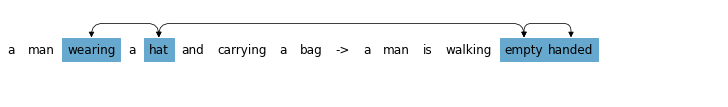





299 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes', 'dryer', 'dryer'), ('nobody', 'drying', 'clothes'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


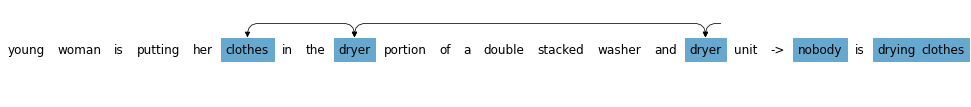





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


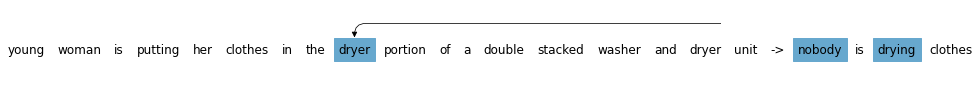





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('Nobody',)), (('unit',), ()), (('washer',), ()), (('a',), ())]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


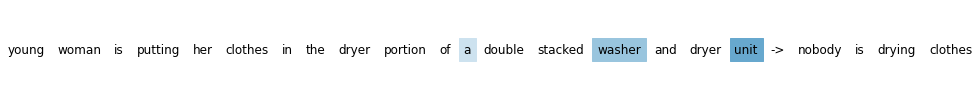





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes',), ('nobody',)), (('putting',), ('nobody',)), (('portion',), ('nobody',)), (('young',), ('nobody',)), (('unit',), ('nobody',)), (('dryer',), ('nobody',)), (('woman',), ('nobody',)), (('washer',), ('nobody',)), (('and',), ('nobody',)), (('is',), ('nobody',)), (('a',), ('nobody',)), (('stacked',), ('nobody',)), (('double',), ('nobody',)), (('her',), ('nobody',)), (('of',), ('nobody',)), (('the',), ('nobody',)), (('in',), ('nobody',))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


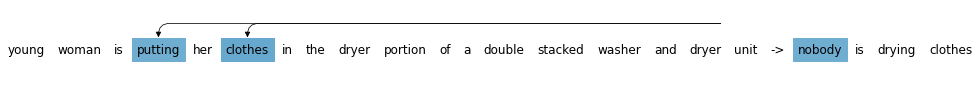





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting',), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody',)), (('clothes',), ('nobody', 'is')), (('washer',), ('nobody', 'drying')), (('clothes', 'washer'), ('nobody',)), (('clothes', 'dryer'), ('nobody',)), (('clothes', 'a'), ('nobody',)), (('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


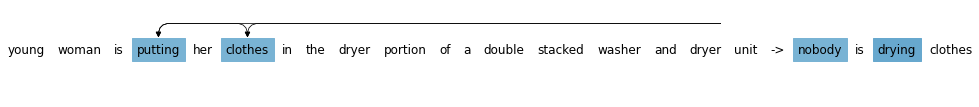





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting', 'a'), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody', 'drying')), (('putting', 'portion'), ('nobody', 'drying')), (('putting', 'washer'), ('nobody', 'drying')), (('woman', 'putting'), ('nobody', 'drying')), (('putting', 'dryer'), ('nobody', 'drying')), (('putting', 'the'), ('nobody', 'drying')), (('putting', 'and'), ('nobody', 'drying')), (('putting', 'unit'), ('nobody', 'drying')), (('putting', 'of'), ('nobody', 'drying')), (('putting', 'double'), ('nobody', 'drying')), (('young', 'putting'), ('nobody', 'drying')), (('putting', 'stacked'), ('nobody', 'drying')), (('is', 'putting'), ('nobody', 'drying')), (('putting',), ('nobody', 'is', 'drying')), (('putting', 'in'), ('nobod

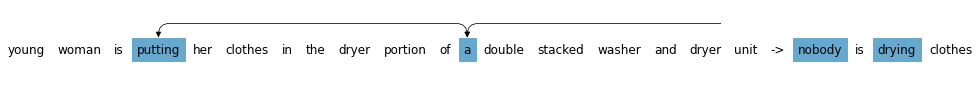





800 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food', 'wine'), ('riding', 'bicycle')), ((), ('down', 'the', 'large'))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


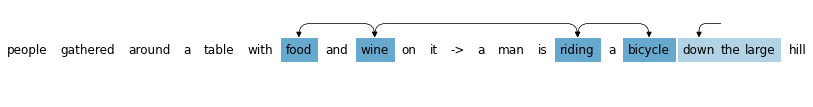





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food', 'wine'), ('bicycle',)), (('food',), ('riding',)), (('table',), ('bicycle',))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


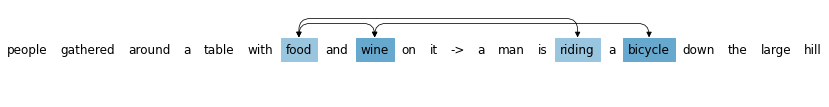





bert-base_lime-5000_test_BT=[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('bicycle',)), ((), ('riding',)), ((), ('hill',)), ((), ('down',)), ((), ('man',)), ((), ('the',)), (('with',), ()), (('food',), ()), ((), ('large',)), (('table',), ()), (('People',), ()), (('gathered',), ()), (('wine',), ()), ((), ('a',)), (('and',), ())]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


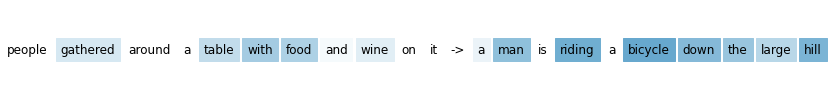





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('food',), ('bicycle',)), (('wine',), ('bicycle',)), (('table',), ('bicycle',)), (('gathered',), ('bicycle',)), (('table',), ('riding',)), (('table',), ('hill',)), (('food',), ('riding',)), (('wine',), ('riding',)), (('people',), ('bicycle',)), (('gathered',), ('riding',)), (('wine',), ('hill',)), (('people',), ('riding',)), (('with',), ('bicycle',)), (('food',), ('hill',)), (('with',), ('riding',)), (('a',), ('bicycle',)), (('around',), ('bicycle',)), (('it',), ('bicycle',)), (('gathered',), ('hill',)), (('people',), ('hill',))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


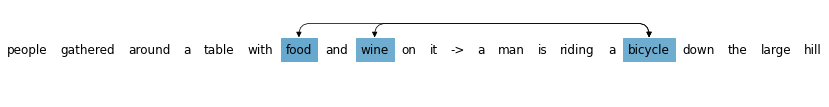





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('table',), ('bicycle', 'down')), (('food',), ('bicycle', 'down')), (('wine',), ('bicycle', 'down')), (('table',), ('riding', 'bicycle')), (('table',), ('riding', 'hill')), (('food',), ('riding', 'bicycle')), (('wine',), ('riding', 'bicycle')), (('wine',), ('riding', 'hill')), (('table',), ('bicycle', 'the')), (('food',), ('bicycle', 'the'))]
interactions_vote: [(['People'], ['man'])]
interactions_union: [(['People', 'gathered', 'around', 'a', 'table'], ['man', 'is', 'riding', 'a', 'bicycle', 'down', 'the', 'large', 'hill'])]


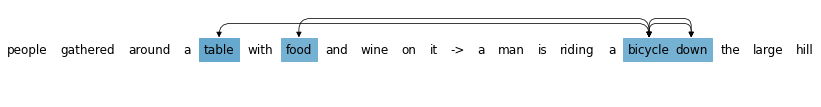





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['People gathered around a table with food and wine on it.', 'A man is riding a bicycle down the large hill.']
gold label: contradiction
pred label: contradiction
explanations: [(('table',), ('bicycle', 'down', 'hill')), (('table',), ('bicycle', 'down', 'the')), (('wine',), ('bicycle', 'down', 'hill')), (('table',), ('riding', 'bicycle', 'down')), (('table', 'wine'), ('bicycle', 'down')), (('table', 'food'), ('bicycle', 'down')), (('food',), ('bicycle', 'down', 'hill')), (('table',), ('riding', 'bicycle', 'hill')), (('wine',), ('riding', 'bicycle', 'down')), (('table',), ('a', 'bicycle', 'down')), (('table',), ('riding', 'down', 'hill')), (('table',), ('bicycle', 'down', 'large')), (('table',), ('man', 'bicycle', 'down')), (('a', 'table'), ('bicycle', 'down')), (('table', 'wine'), ('riding', 'bicycle')), (('food',), ('bicycle', 'down', 'the')), (('table', 'wine'), ('riding', 'hill')), (('gather

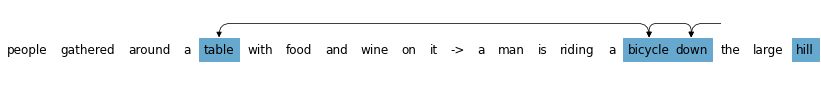





283 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'snow'), ('snowboarding',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


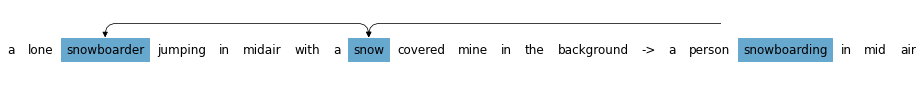





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ('snowboarding',)), (('snow',), ('snowboarding',)), (('midair',), ('mid',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


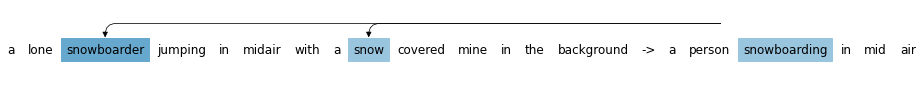





bert-base_lime-5000_test_BT=[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder',), ()), (('midair',), ()), (('jumping',), ()), ((), ('air',)), ((), ('person',)), (('snow',), ()), ((), ('A',)), (('mine',), ()), (('the',), ()), (('in',), ()), (('with',), ())]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


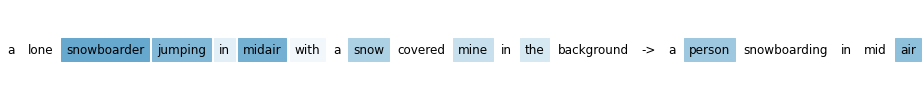





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('jumping',), ('air',)), (('snowboarder',), ('air',)), (('midair',), ('air',)), (('snowboarder',), ('snowboarding',)), (('snowboarder',), ('a',)), (('snowboarder',), ('in',)), (('snow',), ('air',)), (('snowboarder',), ('person',)), (('midair',), ('a',)), (('midair',), ('mid',)), (('snow',), ('snowboarding',)), (('midair',), ('person',)), (('snowboarder',), ('mid',)), (('jumping',), ('a',)), (('snow',), ('a',)), (('midair',), ('in',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in'

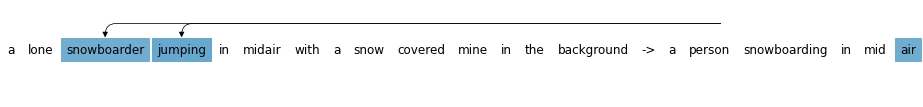





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('air',)), (('snowboarder',), ('air',)), (('snowboarder', 'jumping'), ('a',)), (('midair', 'snow'), ('air',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'midair'), ('mid',)), (('jumping', 'snow'), ('air',))]
interactions_vote: [(['a'], ['person', 'snowboarding']), (['snowboarder', 'jumping', 'in', 'midair'], ['person', 'snowboarding'])]
interactions_union: [(['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['A', 'person', 'snowboarding']), (['a', 'lone', 'snowboarder', 'jumping', 'in', 'midair', 'with'], ['mid', 'air'])]


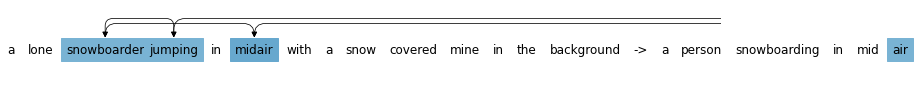





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['a lone snowboarder jumping in midair with a snow covered mine in the background', 'A person snowboarding in mid air']
gold label: entailment
pred label: entailment
explanations: [(('snowboarder', 'jumping'), ('air',)), (('snowboarder', 'jumping', 'snow'), ('air',)), (('snowboarder', 'midair'), ('air',)), (('snowboarder', 'midair', 'snow'), ('air',)), (('snowboarder', 'midair', 'snow'), ('a',)), (('snowboarder', 'midair'), ('a',)), (('snowboarder', 'midair'), ('a', 'air')), (('snowboarder', 'jumping'), ('mid', 'air')), (('snowboarder', 'midair', 'mine'), ('air',)), (('snowboarder', 'midair', 'snow'), ('mid',)), (('snowboarder', 'in', 'midair'), ('air',)), (('snowboarder', 'jumping', 'with'), ('air',)), (('snowboarder', 'midair'), ('mid',)), (('snowboarder', 'midair'), ('snowboarding',)), (('snowboarder', 'jumping', 'midair'), ('air',)), (('snowboarder', 'jumping'), ('in', 'air')), (('snowboard

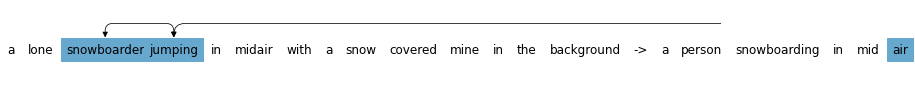





997 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'are', 'people', 'surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


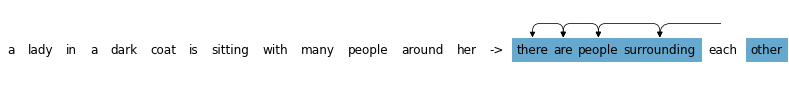





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('a',), ('there',)), (('in',), ('surrounding',)), (('people',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


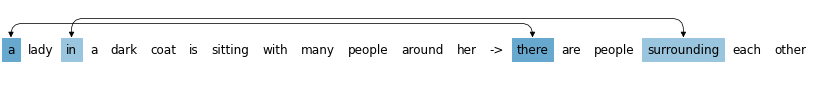





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('surrounding',)), ((), ('There',)), ((), ('are',)), ((), ('people',)), (('people',), ()), (('many',), ()), (('a',), ()), (('around',), ()), (('sitting',), ()), (('with',), ()), (('her',), ()), (('is',), ())]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


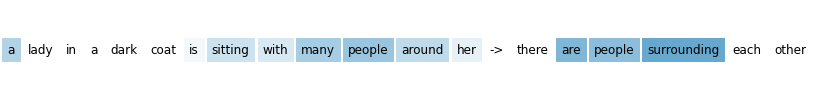





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('surrounding',)), (('people',), ('people',)), (('many',), ('surrounding',)), (('with',), ('surrounding',)), (('around',), ('surrounding',)), (('many',), ('people',)), (('people',), ('there',)), (('is',), ('surrounding',)), (('sitting',), ('surrounding',)), (('her',), ('surrounding',)), (('in',), ('surrounding',)), (('with',), ('people',)), (('coat',), ('surrounding',)), (('a',), ('surrounding',)), (('dark',), ('surrounding',)), (('many',), ('there',)), (('lady',), ('surrounding',)), (('with',), ('there',)), (('in',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surroundin

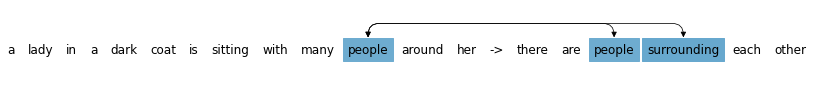





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('people', 'surrounding')), (('people',), ('surrounding', 'each')), (('people',), ('there', 'surrounding')), (('many',), ('people', 'surrounding')), (('people',), ('are', 'surrounding')), (('many', 'around'), ('surrounding',)), (('many',), ('surrounding', 'each')), (('with',), ('surrounding', 'each')), (('with', 'people'), ('surrounding',)), (('people',), ('surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


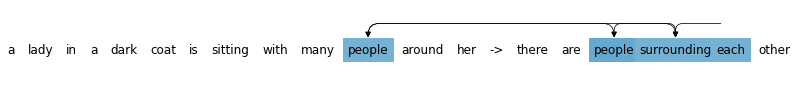





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('many', 'around'), ('people', 'surrounding')), (('with', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'surrounding')), (('people',), ('are', 'people', 'surrounding')), (('people',), ('people', 'surrounding', 'each')), (('with', 'many'), ('people', 'surrounding')), (('people', 'around'), ('people', 'surrounding')), (('many', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'each')), (('people', 'her'), ('people', 'surrounding')), (('in', 'people'), ('people', 'surrounding')), (('is', 'people'), ('people', 'surrounding')), (('sitting', 'people'), ('people', 'surrounding')), (('people',), ('there', 'surrounding', 'each')), (('a', 'people'), ('people', 'surrounding')), (('coat'

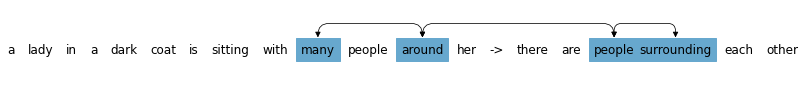

In [75]:
exp_files = ['bert-base_arch-5_test_BT=[MASK].json',
            #  'bert-base_cross_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
             'bert-base_lime-5000_test_BT=[MASK].json',
             'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
             ]


eval_df = pd.read_csv('../eval_results/new/bert-base_mask_explain-3-p0.5-n5000-inv0_interaction_f1_test_vote_10_BT=attention+[MASK]_skip-neutral_only-correct_all.csv', index_col=0)
indices = eval_df['interaction_f1_top2'].sort_values(ascending=False).index.tolist()
top, bottom = indices[:5], indices[-5:]



for test_indices in [top, bottom]:
    for idx in test_indices:
        print(idx, 'score', eval_df['interaction_f1_top2'][idx])
        for exp_file in exp_files:
            with open(f'../explanations/{exp_file}', 'r') as f:
                explanations = json.load(f)
            print(exp_file)
            if 'lime' in exp_file:
                topk = None
            elif 'mask_explain-4' in exp_file:
                topk = 1
            else:
                topk = 2
            analyze_explanation(df, explanations, idx, topk=topk, no_main='lime' not in exp_file)
            print('\n\n\n')


265 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('sitting', 'computer'), ('movies', 'their', 'friends'))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


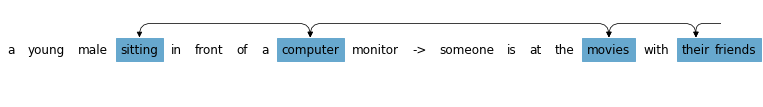





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('movies',)), (('sitting',), ('movies',)), (('computer',), ('the',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


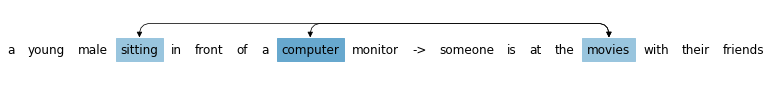





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('movies',)), (('computer',), ()), ((), ('the',)), ((), ('friends',)), ((), ('at',)), (('monitor',), ()), ((), ('their',)), ((), ('with',)), (('of',), ()), (('A',), ()), (('front',), ()), (('in',), ()), ((), ()), (('a',), ()), (('male',), ())]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


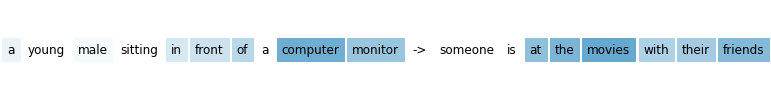





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('movies',)), (('monitor',), ('movies',)), (('front',), ('movies',)), (('sitting',), ('movies',)), (('young',), ('movies',)), (('of',), ('movies',)), (('a',), ('movies',)), (('in',), ('movies',)), (('male',), ('movies',)), (('computer',), ('the',)), (('monitor',), ('the',)), (('monitor',), ('at',)), (('computer',), ('friends',)), (('monitor',), ('friends',)), (('computer',), ('at',)), (('monitor',), ('with',)), (('computer',), ('their',)), (('computer',), ('with',)), (('monitor',), ('their',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'o

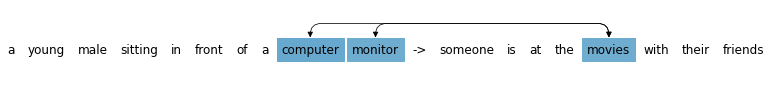





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('at', 'movies')), (('computer',), ('movies', 'with')), (('monitor',), ('at', 'movies')), (('young', 'computer'), ('movies',)), (('computer',), ('the', 'movies')), (('a', 'computer'), ('movies',)), (('monitor',), ('movies', 'with')), (('in', 'computer'), ('movies',)), (('computer',), ('movies', 'friends')), (('of', 'computer'), ('movies',))]
interactions_vote: [(['sitting'], ['at']), (['sitting'], ['movies']), (['front', 'of'], ['at']), (['front', 'of'], ['movies']), (['computer'], ['at']), (['computer'], ['movies'])]
interactions_union: [(['sitting', 'in', 'front', 'of', 'a', 'computer', 'monitor'], ['at', 'the', 'movies'])]


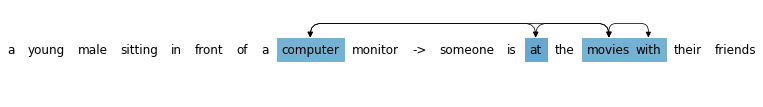





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A young male sitting in front of a computer monitor', 'Someone is at the movies with their friends.']
gold label: contradiction
pred label: contradiction
explanations: [(('computer',), ('at', 'movies', 'with')), (('computer',), ('at', 'the', 'movies')), (('in', 'computer'), ('at', 'movies')), (('front', 'computer'), ('at', 'movies')), (('computer',), ('at', 'movies', 'friends')), (('computer', 'monitor'), ('at', 'movies')), (('young', 'computer'), ('at', 'movies')), (('computer',), ('is', 'at', 'movies')), (('a', 'computer'), ('at', 'movies')), (('sitting', 'computer'), ('at', 'movies')), (('of', 'computer'), ('at', 'movies')), (('computer',), ('at', 'movies', 'their')), (('male', 'computer'), ('at', 'movies')), (('computer',), ('someone', 'at', 'movies')), (('computer',), ('movies', 'with', 'friends')), (('in', 'computer'), ('movies', 'with')), (('young', 'computer'), ('movies', 'with')), ((

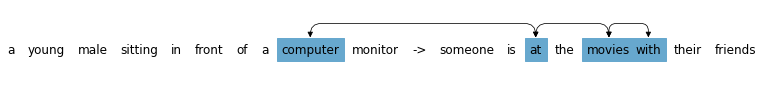





922 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men', 'boxing', 'fighting', 'arena'), ('women', 'fighting'))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


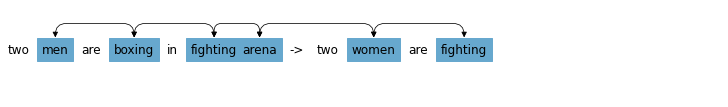





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


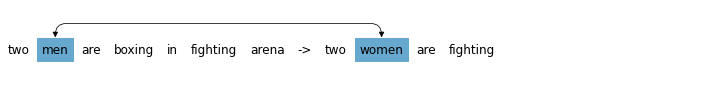





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('women',)), (('men',), ()), (('boxing',), ())]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


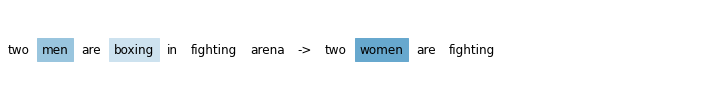





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women',)), (('fighting',), ('women',)), (('in',), ('women',)), (('men',), ('are',)), (('two',), ('women',)), (('are',), ('women',)), (('boxing',), ('women',)), (('men',), ('two',)), (('arena',), ('women',)), (('in',), ('are',)), (('boxing',), ('are',)), (('two',), ('are',)), (('men',), ('fighting',)), (('fighting',), ('are',)), (('arena',), ('are',)), (('in',), ('two',)), (('fighting',), ('two',)), (('are',), ('are',)), (('boxing',), ('two',)), (('are',), ('two',))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


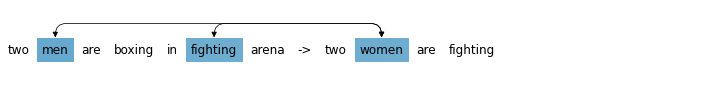





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('women', 'fighting')), (('men',), ('two', 'women')), (('two', 'men'), ('women',)), (('men', 'are'), ('women',)), (('men', 'in'), ('women',)), (('men', 'fighting'), ('women',)), (('men',), ('women',)), (('men', 'arena'), ('women',)), (('men', 'boxing'), ('women',)), (('men',), ('women', 'are'))]
interactions_vote: [(['men'], ['women'])]
interactions_union: [(['men'], ['women'])]


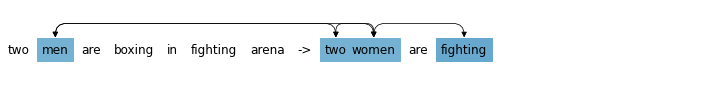





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Two men are boxing in fighting arena.', 'Two women are fighting.']
gold label: contradiction
pred label: contradiction
explanations: [(('men',), ('two', 'women', 'fighting')), (('two', 'men'), ('women', 'fighting')), (('men', 'in'), ('two', 'women')), (('men', 'in'), ('women', 'fighting')), (('two', 'men'), ('two', 'women')), (('men', 'are'), ('two', 'women')), (('two', 'men', 'are'), ('women',)), (('men', 'arena'), ('women', 'fighting')), (('men', 'fighting'), ('women', 'fighting')), (('men', 'arena'), ('two', 'women')), (('men', 'in', 'arena'), ('women',)), (('men', 'are'), ('women', 'fighting')), (('two', 'men', 'in'), ('women',)), (('men', 'are', 'in'), ('women',)), (('men', 'fighting'), ('two', 'women')), (('men', 'in', 'fighting'), ('women',)), (('two', 'men', 'fighting'), ('women',)), (('two', 'men', 'arena'), ('women',)), (('men', 'are', 'fighting'), ('women',)), (('men', 'are', 'aren

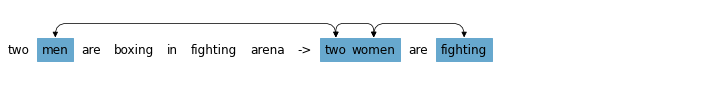





770 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('there', 'adult'))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


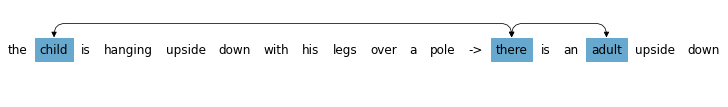





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('adult',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


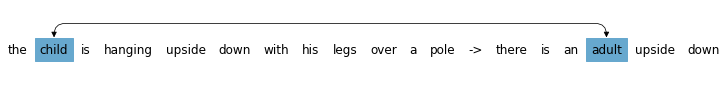





bert-base_lime-5000_test_BT=[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ()), ((), ('adult',)), (('pole',), ()), ((), ('upside',)), ((), ()), (('with',), ()), ((), ('down',)), (('a',), ())]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


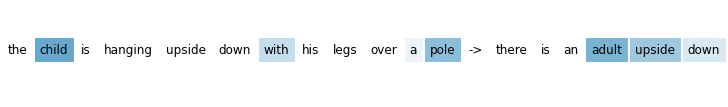





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child',), ('adult',)), (('child',), ('is',)), (('pole',), ('adult',)), (('over',), ('adult',)), (('the',), ('adult',)), (('legs',), ('adult',)), (('a',), ('adult',)), (('his',), ('adult',)), (('child',), ('down',)), (('with',), ('adult',)), (('child',), ('upside',)), (('down',), ('adult',)), (('is',), ('adult',)), (('hanging',), ('adult',)), (('child',), ('an',)), (('upside',), ('adult',)), (('child',), ('there',)), (('pole',), ('is',)), (('with',), ('is',)), (('a',), ('is',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


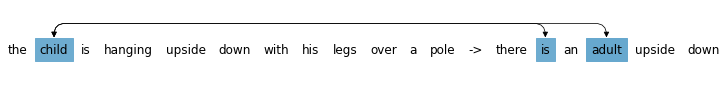





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child', 'pole'), ('adult',)), (('child', 'legs'), ('adult',)), (('child', 'his'), ('adult',)), (('child',), ('adult', 'down')), (('child', 'a'), ('adult',)), (('child',), ('an', 'adult')), (('child',), ('adult',)), (('child', 'over'), ('adult',)), (('child',), ('adult', 'upside')), (('child', 'down'), ('adult',))]
interactions_vote: [(['child'], ['adult'])]
interactions_union: [(['The', 'child', 'is', 'hanging', 'upside', 'down'], ['an', 'adult'])]


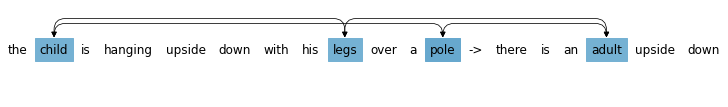





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['The child is hanging upside down with his legs over a pole.', 'There is an adult upside down.']
gold label: contradiction
pred label: contradiction
explanations: [(('child', 'legs', 'a'), ('adult',)), (('child', 'a', 'pole'), ('adult',)), (('child', 'legs', 'pole'), ('adult',)), (('child', 'down', 'pole'), ('adult',)), (('child', 'legs'), ('an', 'adult')), (('child', 'down', 'legs'), ('adult',)), (('child', 'pole'), ('adult', 'down')), (('child', 'his', 'a'), ('adult',)), (('child', 'his', 'pole'), ('adult',)), (('child', 'pole'), ('an', 'adult')), (('child', 'with', 'legs'), ('adult',)), (('child', 'his', 'legs'), ('adult',)), (('child', 'down', 'his'), ('adult',)), (('child', 'a'), ('adult', 'down')), (('child', 'legs'), ('adult', 'down')), (('child', 'over', 'pole'), ('adult',)), (('child', 'pole'), ('adult', 'upside')), (('child', 'legs', 'over'), ('adult',)), (('child', 'with', 'his'), (

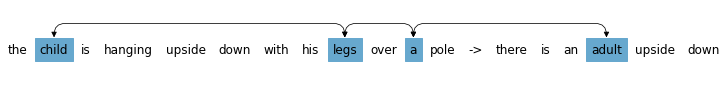





813 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'sign', 'hugs'), ('woman', 'holding', 'sign'))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


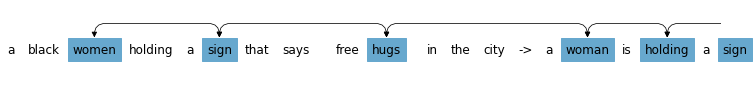





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('sign',), ('sign',))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


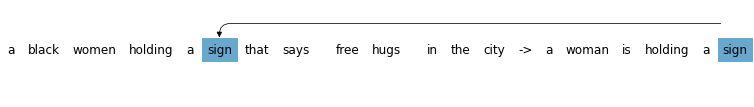





bert-base_lime-5000_test_BT=[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women',), ()), ((), ('holding',)), ((), ('sign',)), (('hugs',), ()), (('holding',), ()), ((), ('a',)), (('says',), ()), (('a',), ()), (('that',), ()), ((), ())]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


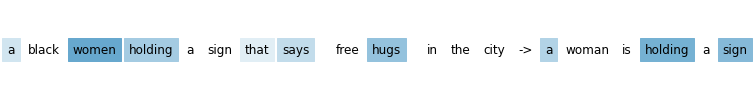





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women',), ('holding',)), (('women',), ('sign',)), (('holding',), ('holding',)), (('sign',), ('sign',)), (('women',), ('a',)), (('women',), ('woman',)), (('hugs',), ('holding',)), (('sign',), ('holding',)), (('holding',), ('sign',)), (('says',), ('sign',)), (('a',), ('sign',)), (('that',), ('sign',)), (('free',), ('holding',)), (('that',), ('holding',)), (('free',), ('sign',)), (('black',), ('sign',)), (('a',), ('holding',)), (('in',), ('sign',))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


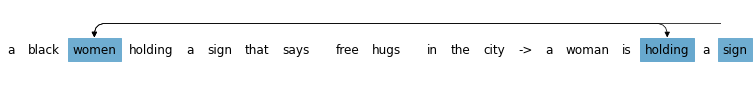





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'holding'), ('holding',)), (('women', 'sign'), ('sign',)), (('women', 'sign'), ('holding',)), (('women', 'holding'), ('sign',)), (('women', 'hugs'), ('holding',)), (('women', 'says'), ('sign',)), (('women', 'a'), ('holding',)), (('women',), ('is', 'holding')), (('women', 'a'), ('sign',)), (('women',), ('a', 'sign'))]
interactions_vote: [(['women', 'holding'], ['woman']), (['women', 'holding'], ['holding']), (['women', 'holding'], ['sign']), (['sign'], ['woman']), (['sign'], ['holding']), (['sign'], ['sign'])]
interactions_union: [(['black', 'women', 'holding', 'a', 'sign'], ['woman', 'is', 'holding', 'a', 'sign'])]


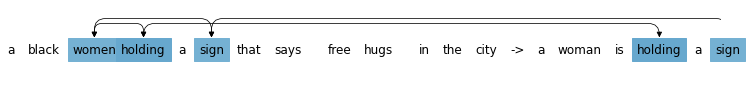





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ["A black women holding a sign that says, 'free hugs' in the city.", 'a woman is holding a sign']
gold label: entailment
pred label: entailment
explanations: [(('women', 'holding', 'sign'), ('holding',)), (('women', 'holding', 'that'), ('holding',)), (('women', 'holding', 'says'), ('holding',)), (('women', 'holding', 'a'), ('holding',)), (('black', 'women', 'holding'), ('holding',)), (('women', 'holding', 'free'), ('holding',)), (('women', 'holding'), ('is', 'holding')), (('women', 'holding'), ('woman', 'holding')), (('women', 'holding'), ('holding', 'a')), (('women', 'holding', 'city'), ('holding',)), (('women', 'holding', 'in'), ('holding',)), (('women', 'holding'), ('a', 'holding')), (('a', 'women', 'holding'), ('holding',)), (('women', 'holding', 'the'), ('holding',)), (('women', 'holding', 'hugs'), ('holding',)), (('women', 'sign'), ('a', 'sign')), (('women', 'holding', 'sign'), ('sign',))

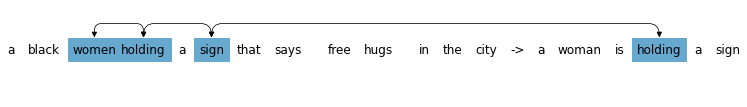





749 score 1.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('there', 'are', 'no', 'the'))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


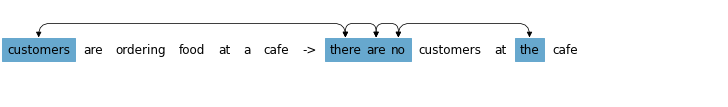





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no',))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


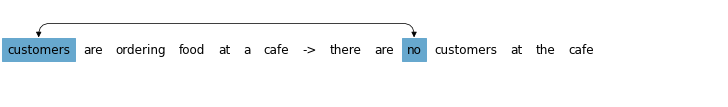





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('no',)), (('are',), ()), ((), ())]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


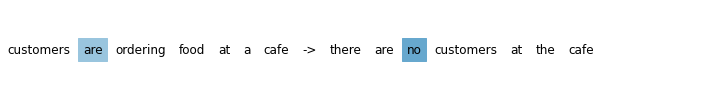





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no',)), (('ordering',), ('no',)), (('food',), ('no',)), (('are',), ('no',)), (('at',), ('no',)), (('a',), ('no',)), (('cafe',), ('no',)), (('ordering',), ('are',)), (('ordering',), ('the',)), (('food',), ('the',)), (('ordering',), ('cafe',)), (('food',), ('are',)), (('at',), ('the',)), (('are',), ('the',)), (('at',), ('are',)), (('customers',), ('the',)), (('are',), ('are',)), (('a',), ('are',)), (('ordering',), ('there',)), (('food',), ('there',))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


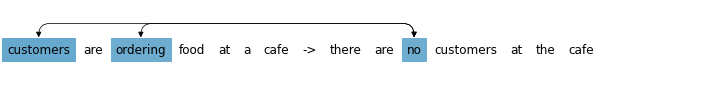





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers',), ('no', 'customers')), (('customers',), ('there', 'no')), (('food',), ('there', 'no')), (('ordering',), ('there', 'no')), (('ordering',), ('no', 'customers')), (('customers',), ('no', 'at')), (('food',), ('no', 'customers')), (('customers',), ('are', 'no')), (('are',), ('there', 'no')), (('ordering',), ('are', 'no'))]
interactions_vote: [(['Customers'], ['no'])]
interactions_union: [(['Customers', 'are'], ['no', 'customers']), (['Customers', 'are'], ['cafe'])]


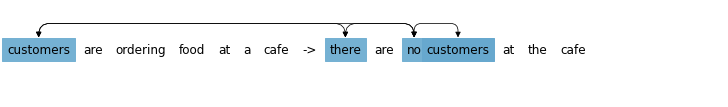





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Customers are ordering food at a cafe.', 'There are no customers at the cafe.']
gold label: contradiction
pred label: contradiction
explanations: [(('customers', 'at'), ('no', 'customers')), (('customers',), ('there', 'no', 'customers')), (('customers',), ('no', 'customers', 'at')), (('customers', 'food'), ('no', 'customers')), (('customers',), ('are', 'no', 'customers')), (('customers',), ('no', 'customers', 'cafe')), (('customers', 'are'), ('no', 'customers')), (('customers', 'a'), ('no', 'customers')), (('customers',), ('no', 'customers', 'the')), (('customers', 'ordering'), ('no', 'customers')), (('customers', 'cafe'), ('no', 'customers')), (('customers',), ('there', 'no', 'at')), (('customers',), ('there', 'no', 'cafe')), (('customers',), ('there', 'are', 'no')), (('customers', 'food'), ('there', 'no')), (('customers', 'cafe'), ('there', 'no')), (('customers', 'at'), ('there', 'no')), ((

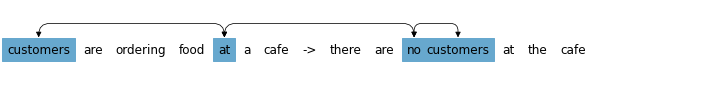





751 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


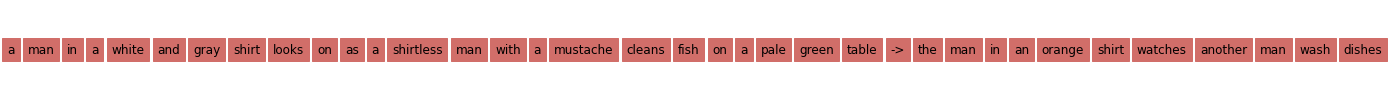





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: []
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


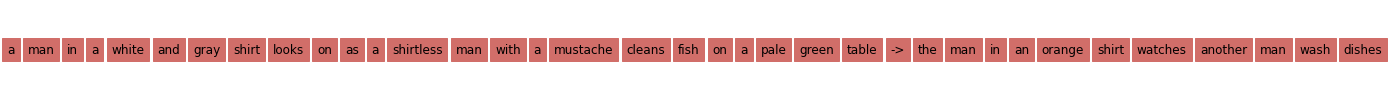





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('orange',)), ((), ('wash',)), (('white',), ()), ((), ('dishes',)), (('shirtless',), ()), (('gray',), ()), ((), ('shirt',)), ((), ('in',)), (('a',), ()), (('fish',), ()), (('man',), ())]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


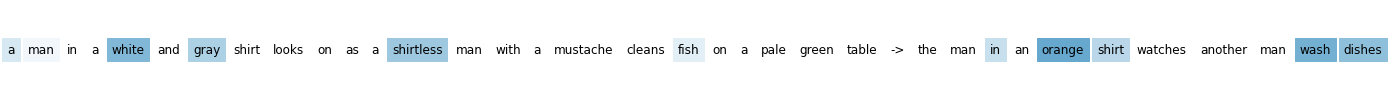





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('white',), ('orange',)), (('gray',), ('orange',)), (('shirtless',), ('orange',)), (('in',), ('orange',)), (('green',), ('orange',)), (('shirt',), ('orange',)), (('on',), ('orange',)), (('man',), ('orange',)), (('pale',), ('orange',)), (('with',), ('orange',)), (('a',), ('orange',)), (('mustache',), ('orange',)), (('fish',), ('orange',)), (('cleans',), ('orange',))]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


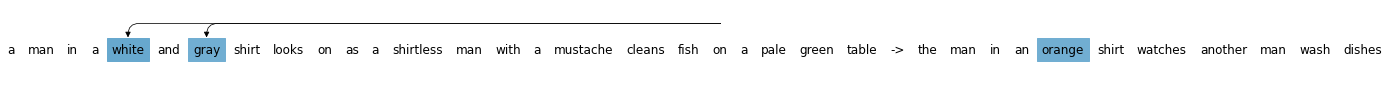





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('gray', 'shirt'), ('orange',)), (('in', 'white'), ('orange',)), (('white', 'shirt'), ('orange',)), (('white', 'shirtless'), ('orange',)), (('gray', 'shirtless'), ('orange',)), (('white',), ('orange', 'watches')), (('in', 'gray'), ('orange',)), (('a', 'white'), ('orange',)), (('white',), ('in', 'orange'))]
interactions_vote: [(['white', 'and', 'gray'], ['orange', 'shirt'])]
interactions_union: [(['white', 'and', 'gray', 'shirt'], ['orange', 'shirt']), (['white', 'and', 'gray', 'shirt'], ['wash', 'dishes']), (['cleans', 'fish'], ['orange', 'shirt']), (['cleans', 'fish'], ['wash', 'dishes'])]


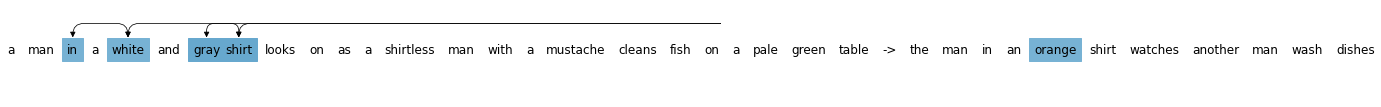





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A man in a white and gray shirt looks on as a shirtless man with a mustache cleans fish on a pale green table.', 'The man in an orange shirt watches another man wash dishes.']
gold label: contradiction
pred label: contradiction
explanations: [(('gray', 'shirt'), ('orange', 'shirt')), (('white', 'shirt'), ('orange', 'shirt')), (('white',), ('orange', 'wash', 'dishes')), (('gray', 'shirtless'), ('orange', 'dishes')), (('in', 'white'), ('in', 'orange')), (('gray', 'shirt'), ('in', 'orange')), (('in', 'gray'), ('in', 'orange')), (('gray', 'shirtless'), ('in', 'orange')), (('gray', 'shirtless'), ('orange',)), (('white', 'shirt', 'green'), ('orange',)), (('white', 'shirtless'), ('orange', 'dishes')), (('gray', 'shirt'), ('orange', 'dishes')), (('white', 'shirtless'), ('in', 'orange')), (('gray',), ('orange', 'wash', 'dishes')), (('gray', 'shirt'), ('orange', 'watches')), (('white', 'gray', 'shirt')

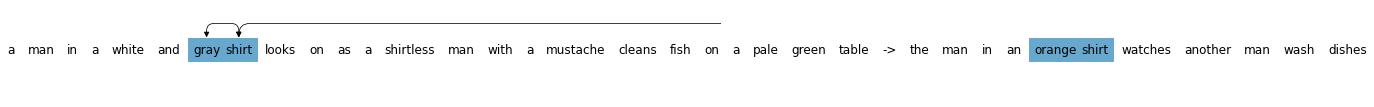





306 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'two', 'in', 'photo')), (('cars',), ('vehicles',)), (('police',), ('police',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


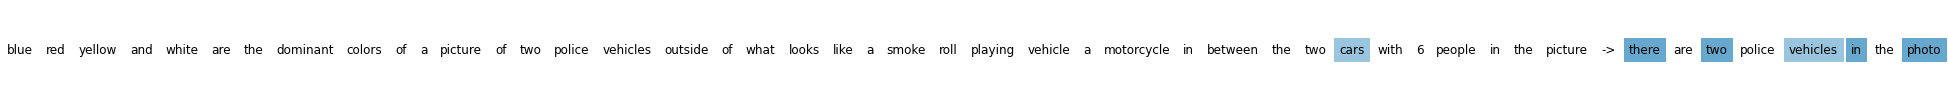





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('cars',), ('vehicles',)), (('motorcycle',), ('vehicles',)), (('police',), ('police',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


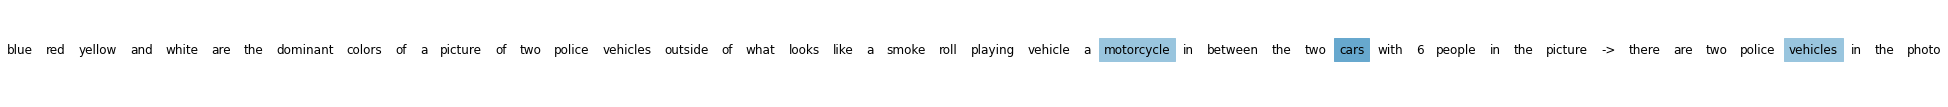





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ()), ((), ('vehicles',)), ((), ('There',)), ((), ('two',)), ((), ('photo',)), ((), ('are',)), (('roll',), ()), (('motorcycle',), ()), ((), ('in',)), (('are',), ()), (('6',), ()), (('like',), ()), (('a',), ())]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), (['picture'], ['police']), (['picture'], ['photo'])]


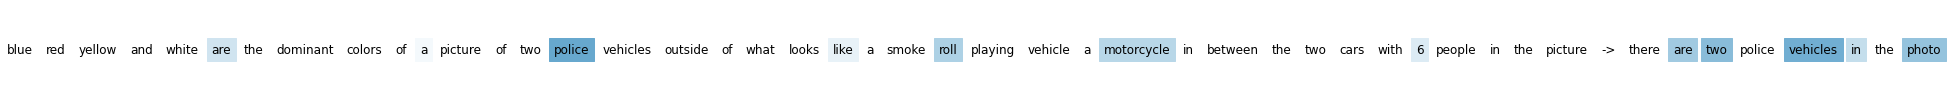





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('vehicles',)), (('police',), ('there',)), (('police',), ('photo',)), (('police',), ('in',)), (('police',), ('are',)), (('police',), ('the',)), (('police',), ('police',)), (('police',), ('two',)), (('motorcycle',), ('vehicles',)), (('cars',), ('vehicles',)), (('of',), ('vehicles',)), (('people',), ('vehicles',)), (('two',), ('vehicles',)), (('red',), ('vehicles',)), (('vehicles',), ('vehicles',)), (('in',), ('vehicles',)), (('the',), ('vehicles',)), (('like',), ('vehicles',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['Th

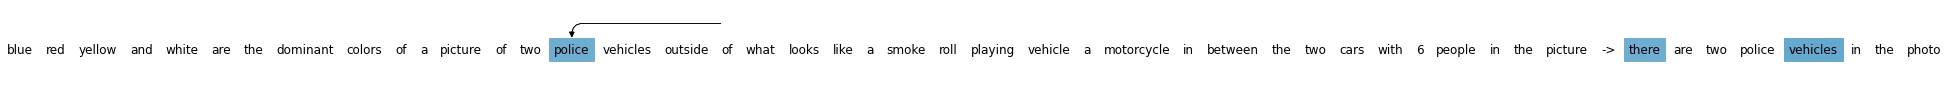





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('vehicles', 'photo')), (('police',), ('there', 'vehicles')), (('police', 'cars'), ('vehicles',)), (('two', 'police'), ('vehicles',)), (('two', 'police'), ('there',)), (('dominant', 'police'), ('vehicles',)), (('police', 'a'), ('vehicles',)), (('police', 'two'), ('vehicles',)), (('police', 'of'), ('vehicles',)), (('police', 'motorcycle'), ('vehicles',))]
interactions_vote: [(['vehicles'], ['photo'])]
interactions_union: [(['police', 'vehicles'], ['There', 'are']), (['police', 'vehicles'], ['police']), (['police', 'vehicles'], ['photo']), (['picture'], ['There', 'are']), ([

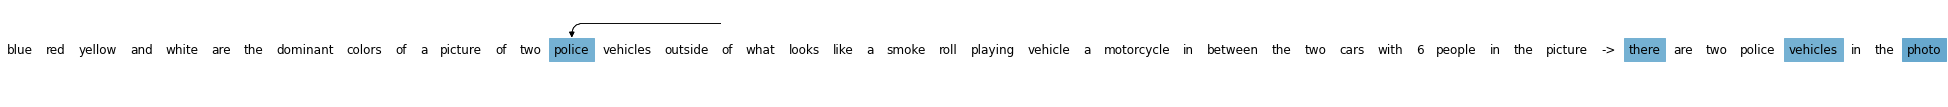





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Blue, red, yellow, and white are the dominant colors of a picture of two police vehicles outside of what looks like a smoke roll playing vehicle, a motorcycle in between the two cars with 6 people in the picture.', 'There are two police vehicles in the photo.']
gold label: entailment
pred label: entailment
explanations: [(('police',), ('there', 'vehicles', 'photo')), (('police',), ('vehicles', 'in', 'photo')), (('police', 'cars'), ('there', 'vehicles')), (('police', 'two'), ('there', 'vehicles')), (('two', 'police'), ('there', 'vehicles')), (('police', 'cars'), ('vehicles', 'photo')), (('police', 'motorcycle'), ('there', 'vehicles')), (('police', 'vehicles'), ('there', 'vehicles')), (('police', 'motorcycle'), ('vehicles', 'photo')), (('police',), ('there', 'are', 'vehicles')), (('police', 'in'), ('there', 'vehicles')), (('two', 'police'), ('vehicles', 'photo')), (('police', 'vehicle'), ('ther

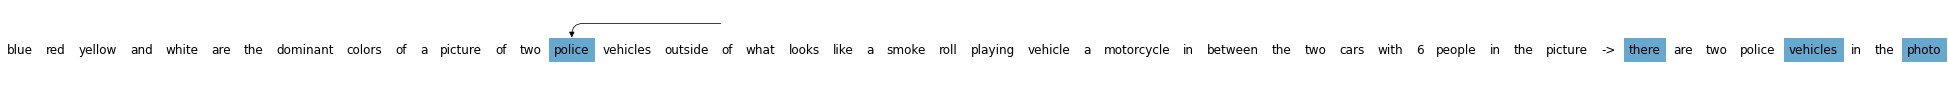





767 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('pool',), ('water',)), ((), ('moving', 'toward')), ((), ('is', 'a'))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


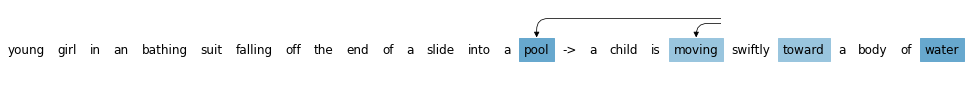





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving',)), (('bathing',), ('water',)), (('pool',), ('water',)), (('bathing',), ('of',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


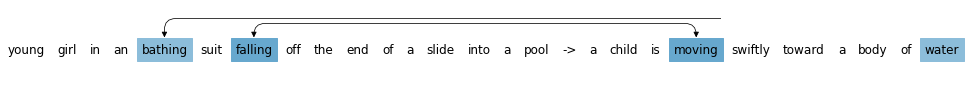





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [((), ('moving',)), ((), ('water',)), ((), ('body',)), (('falling',), ()), (('girl',), ()), (('off',), ()), (('into',), ()), ((), ('a',)), ((), ('toward',)), ((), ('of',)), ((), ('child',)), (('slide',), ()), (('suit',), ()), (('in',), ()), (('Young',), ()), (('an',), ()), ((), ('A',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


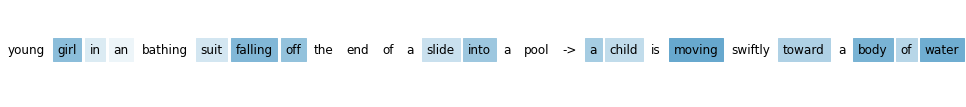





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving',)), (('slide',), ('moving',)), (('into',), ('moving',)), (('girl',), ('moving',)), (('falling',), ('water',)), (('end',), ('moving',)), (('off',), ('moving',)), (('young',), ('moving',)), (('the',), ('moving',)), (('suit',), ('moving',)), (('an',), ('moving',)), (('in',), ('moving',)), (('of',), ('moving',)), (('bathing',), ('moving',)), (('pool',), ('moving',)), (('a',), ('moving',)), (('into',), ('water',)), (('girl',), ('water',)), (('falling',), ('of',))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (

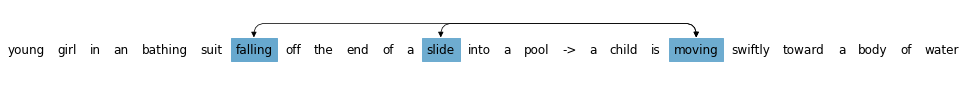





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('moving', 'water')), (('slide',), ('moving', 'water')), (('girl', 'falling'), ('moving',)), (('falling',), ('moving', 'of')), (('slide', 'into'), ('moving',)), (('falling', 'into'), ('moving',)), (('falling',), ('moving', 'toward')), (('into',), ('moving', 'water')), (('falling',), ('moving', 'body')), (('falling',), ('a', 'moving'))]
interactions_vote: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body']), (['Young', 'girl'], ['water']), (['pool'], ['child']), (['pool'], ['body']), (['pool'], ['water'])]
interactions_union: [(['Young', 'girl'], ['child']), (['Young', 'girl'], ['body', 'of', 'water']), (['pool'], ['child']), (['pool'], ['body', 'of', 'water'])]


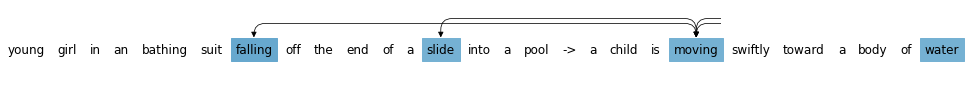





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young girl in an bathing suit falling off the end of a slide into a pool.', 'A child is moving swiftly toward a body of water.']
gold label: entailment
pred label: entailment
explanations: [(('falling',), ('a', 'moving', 'water')), (('falling',), ('moving', 'body', 'water')), (('slide',), ('moving', 'body', 'water')), (('falling',), ('moving', 'body', 'of')), (('falling',), ('moving', 'toward', 'water')), (('girl', 'falling'), ('moving', 'water')), (('slide', 'into'), ('moving', 'water')), (('slide',), ('a', 'moving', 'water')), (('girl', 'falling'), ('a', 'moving')), (('girl', 'falling'), ('child', 'moving')), (('slide', 'into'), ('moving', 'body')), (('falling',), ('a', 'moving', 'of')), (('slide', 'into'), ('moving', 'of')), (('girl', 'falling'), ('moving', 'toward')), (('falling', 'slide'), ('moving', 'body')), (('into',), ('moving', 'body', 'water')), (('girl', 'falling'), ('moving', 'bo

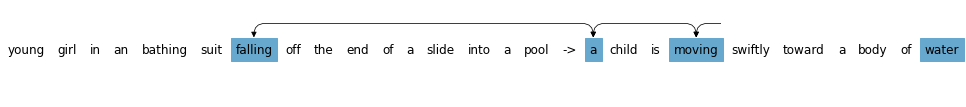





299 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes', 'dryer', 'dryer'), ('nobody', 'drying', 'clothes'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


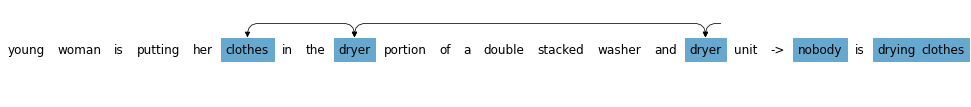





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


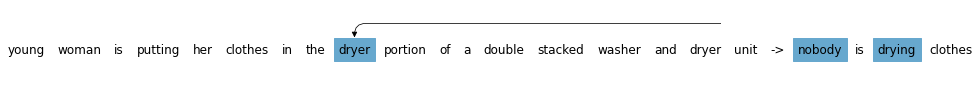





bert-base_lime-5000_test_BT=[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [((), ('Nobody',)), (('unit',), ()), (('washer',), ()), (('a',), ())]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


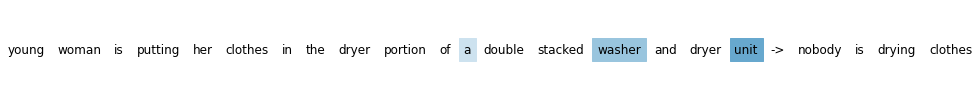





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('clothes',), ('nobody',)), (('putting',), ('nobody',)), (('portion',), ('nobody',)), (('young',), ('nobody',)), (('unit',), ('nobody',)), (('dryer',), ('nobody',)), (('woman',), ('nobody',)), (('washer',), ('nobody',)), (('and',), ('nobody',)), (('is',), ('nobody',)), (('a',), ('nobody',)), (('stacked',), ('nobody',)), (('double',), ('nobody',)), (('her',), ('nobody',)), (('of',), ('nobody',)), (('the',), ('nobody',)), (('in',), ('nobody',))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


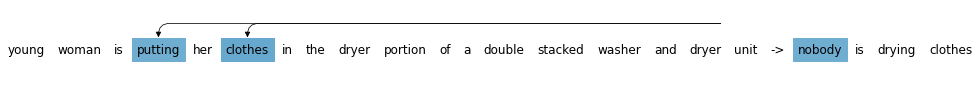





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting',), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody',)), (('clothes',), ('nobody', 'is')), (('washer',), ('nobody', 'drying')), (('clothes', 'washer'), ('nobody',)), (('clothes', 'dryer'), ('nobody',)), (('clothes', 'a'), ('nobody',)), (('dryer',), ('nobody', 'drying'))]
interactions_vote: [(['woman'], ['Nobody'])]
interactions_union: [(['Young', 'woman'], ['Nobody'])]


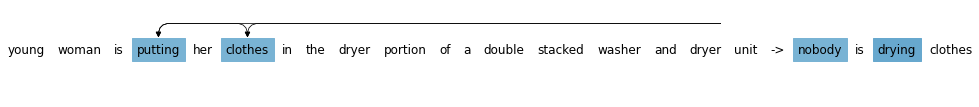





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['Young woman is putting her clothes in the dryer portion of a double stacked washer and dryer unit.', 'Nobody is drying clothes.']
gold label: contradiction
pred label: contradiction
explanations: [(('putting', 'a'), ('nobody', 'drying')), (('putting', 'clothes'), ('nobody', 'drying')), (('putting', 'portion'), ('nobody', 'drying')), (('putting', 'washer'), ('nobody', 'drying')), (('woman', 'putting'), ('nobody', 'drying')), (('putting', 'dryer'), ('nobody', 'drying')), (('putting', 'the'), ('nobody', 'drying')), (('putting', 'and'), ('nobody', 'drying')), (('putting', 'unit'), ('nobody', 'drying')), (('putting', 'of'), ('nobody', 'drying')), (('putting', 'double'), ('nobody', 'drying')), (('young', 'putting'), ('nobody', 'drying')), (('putting', 'stacked'), ('nobody', 'drying')), (('is', 'putting'), ('nobody', 'drying')), (('putting',), ('nobody', 'is', 'drying')), (('putting', 'in'), ('nobod

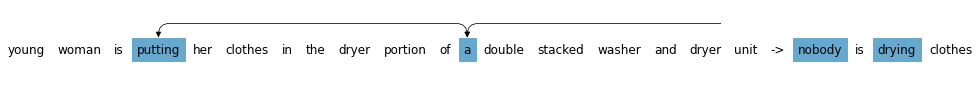





997 score 0.0
bert-base_arch-5_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('there', 'are', 'people', 'surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


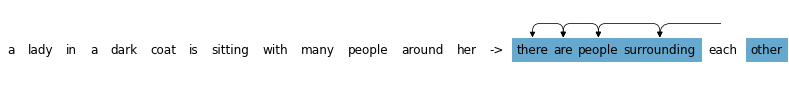





bert-base_cross_arch-5_test_BT=[MASK]_X.json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('a',), ('there',)), (('in',), ('surrounding',)), (('people',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


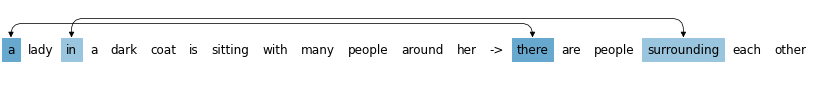





bert-base_lime-5000_test_BT=[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [((), ('surrounding',)), ((), ('There',)), ((), ('are',)), ((), ('people',)), (('people',), ()), (('many',), ()), (('a',), ()), (('around',), ()), (('sitting',), ()), (('with',), ()), (('her',), ()), (('is',), ())]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


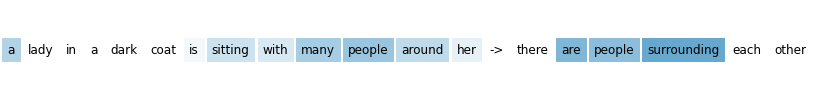





bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('surrounding',)), (('people',), ('people',)), (('many',), ('surrounding',)), (('with',), ('surrounding',)), (('around',), ('surrounding',)), (('many',), ('people',)), (('people',), ('there',)), (('is',), ('surrounding',)), (('sitting',), ('surrounding',)), (('her',), ('surrounding',)), (('in',), ('surrounding',)), (('with',), ('people',)), (('coat',), ('surrounding',)), (('a',), ('surrounding',)), (('dark',), ('surrounding',)), (('many',), ('there',)), (('lady',), ('surrounding',)), (('with',), ('there',)), (('in',), ('people',))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surroundin

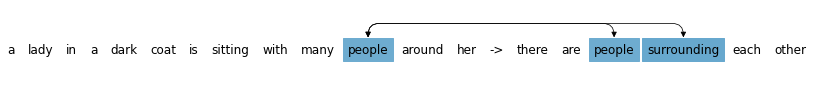





bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('people',), ('people', 'surrounding')), (('people',), ('surrounding', 'each')), (('people',), ('there', 'surrounding')), (('many',), ('people', 'surrounding')), (('people',), ('are', 'surrounding')), (('many', 'around'), ('surrounding',)), (('many',), ('surrounding', 'each')), (('with',), ('surrounding', 'each')), (('with', 'people'), ('surrounding',)), (('people',), ('surrounding', 'other'))]
interactions_vote: [(['many'], ['surrounding', 'each', 'other']), (['around'], ['surrounding', 'each', 'other'])]
interactions_union: [(['many', 'people', 'around', 'her'], ['people', 'surrounding', 'each', 'other'])]


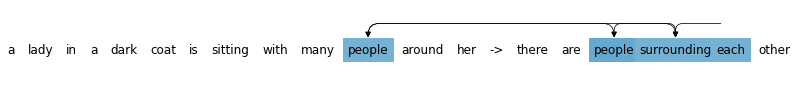





bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json
texts: ['A lady in a dark coat is sitting with many people around her.', 'There are people surrounding each other.']
gold label: entailment
pred label: entailment
explanations: [(('many', 'around'), ('people', 'surrounding')), (('with', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'surrounding')), (('people',), ('are', 'people', 'surrounding')), (('people',), ('people', 'surrounding', 'each')), (('with', 'many'), ('people', 'surrounding')), (('people', 'around'), ('people', 'surrounding')), (('many', 'people'), ('people', 'surrounding')), (('people',), ('there', 'people', 'each')), (('people', 'her'), ('people', 'surrounding')), (('in', 'people'), ('people', 'surrounding')), (('is', 'people'), ('people', 'surrounding')), (('sitting', 'people'), ('people', 'surrounding')), (('people',), ('there', 'surrounding', 'each')), (('a', 'people'), ('people', 'surrounding')), (('coat'

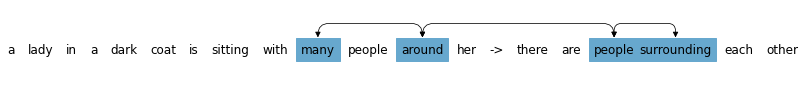

In [78]:
exp_files = ['bert-base_arch-5_test_BT=[MASK].json',
            #  'bert-base_cross_arch-5_test_BT=[MASK].json',
             'bert-base_cross_arch-5_test_BT=[MASK]_X.json',
             'bert-base_lime-5000_test_BT=[MASK].json',
             'bert-base_mask_explain-2-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-3-p0.5-n5000-inv0_test_BT=attention+[MASK].json',
             'bert-base_mask_explain-4-p0.5-n5000-inv0-buildup0.3_test_BT=attention+[MASK].json',
             ]


eval_df = pd.read_csv('../eval_results/new/bert-base_cross_arch-5_interaction_f1_test_vote_10_BT=[MASK]_X_skip-neutral_only-correct_all.csv', index_col=0)
indices = eval_df['interaction_f1_top2'].sort_values(ascending=False).index.tolist()
top, bottom = indices[:5], indices[-5:]



for test_indices in [top, bottom]:
    for idx in test_indices:
        print(idx, 'score', eval_df['interaction_f1_top2'][idx])
        for exp_file in exp_files:
            with open(f'../explanations/{exp_file}', 'r') as f:
                explanations = json.load(f)
            print(exp_file)
            if 'lime' in exp_file:
                topk = None
            elif 'mask_explain-4' in exp_file:
                topk = 1
            else:
                topk = 2
            analyze_explanation(df, explanations, idx, topk=topk, no_main='lime' not in exp_file)
            print('\n\n\n')